Explore classifier that assesses each calorimeter layer one by one and then try concatenating them

Start with each layer individually, then start merging them, then at the end try to optimize the regularizers/dropout for the merged model. gets pretty good! Very last model is my best

In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'

import sys
sys.path.append(path_prefix)
import resolution_util as ru
import plot_util as pu
import ml_util as mu

import tensorflow as tf

from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, concatenate
from tensorflow.keras import Model
from tensorflow import keras

In [3]:
# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [4]:
inputpath = '/fast_scratch/atlas_images/v7/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
rootfiles = ["pi0", "piplus", "piminus"]
trees = {rfile : ur.open(inputpath+rfile+".root")['ClusterTree'] for rfile in rootfiles}
pdata = {ifile : pd.DataFrame(itree.arrays(expressions = branches, library='np')) for ifile, itree in trees.items()}
#so the above two are just defining new dictionaries using other dictionaries lol

In [5]:
cell_shapes = {'EMB1': (128,4), 'EMB2': (16,16), 'EMB3': (8,16), 'TileBar0': (4,4), 'TileBar1': (4,4), 'TileBar2': (2,4)}
#nested dictionary definitions
pcells = {ifile : {layer : mu.setupCells(itree, layer) for layer in layers} for ifile, itree in trees.items()}

In [6]:
training_dataset = ['pi0','piplus']
for i in enumerate(training_dataset): #outputs of enumerate: index, label (see below!)
    print(i)

(0, 'pi0')
(1, 'piplus')


In [7]:
# create train/validation/test subsets containing 70%/10%/20% of events from each type of pion event
for p_index, plabel in enumerate(training_dataset):
    mu.splitFrameTVT(pdata[plabel],trainfrac=0.7)
    pdata[plabel]['label'] = p_index

In [8]:
pdata['pi0']

runNumber  eventNumber      truthE     truthPt  truthEta  truthPhi  \
0          284500         1763  532.180603  433.847717  0.661171  2.553774   
1          284500         1500    7.640409    7.639162 -0.003771 -0.221088   
2          284500           25    5.514576    5.512368  0.014204 -0.091146   
3          284500           25    5.514576    5.512368  0.014204 -0.091146   
4          284500          417   24.719658   21.158272  0.572335 -1.457298   
...           ...          ...         ...         ...       ...       ...   
263886     284500       376244  932.972351  915.220886  0.196639  0.441251   
263887     284500       375405    1.626860    1.616192 -0.079096 -0.062043   
263888     284500       376638  475.428680  427.576721 -0.468800 -1.415947   
263889     284500       376674  137.269974  109.587692  0.696608 -2.881032   
263890     284500       376077    0.329255    0.293575  0.213903 -1.934596   

        clusterIndex  nCluster    clusterE  clusterECalib  ...  \
0                  0         1  522.347168     531.995789  ...   
1                  0         1    6.733534       8.309240  ...   
2                  0         2    2.788937       3.465582  ...   
3                  1         2    1.246055       1.994231  ...   
4                  0         1   23.665634      25.394232  ...   
...              ...       ...         ...            ...  ...   
263886             0         1  908.714111     926.805603  ...   
263887             0         1    0.872110       1.478907  ...   
263888             0         1  466.900146     480.174408  ...   
263889             0         1  132.834503     137.719467  ...   
263890             0         1    0.303065       0.652258  ...   

        cluster_cell_dPhi_min  cluster_cell_dPhi_max  \
0                    0.011096              -0.148300   
1                    0.002001               0.087686   
2                   -0.002291              -0.088563   
3                    0.015331              -0.119879   
4                    0.007418              -0.090538   
...                       ...                    ...   
263886              -0.003901              -0.097016   
263887               0.000237               0.012701   
263888              -0.003225               0.082583   
263889              -0.001111               0.182907   
263890               0.004200              -0.032506   

        cluster_cell_centerCellEta  cluster_cell_centerCellPhi  \
0                         0.688814                    2.564107   
1                        -0.035842                   -0.231482   
2                         0.013590                   -0.066747   
3                        -0.010854                    0.185748   
4                         0.587316                   -1.439919   
...                            ...                         ...   
263886                    0.181233                    0.436726   
263887                   -0.018430                   -0.145797   
263888                   -0.471042                   -1.420709   
263889                    0.662679                   -2.884897   
263890                    0.258317                   -1.819480   

        cluster_cell_centerCellLayer  \
0                                  2   
1                                  2   
2                                  2   
3                                  2   
4                                  2   
...                              ...   
263886                             1   
263887                             1   
263888                             1   
263889                             2   
263890                             1   

                                       cluster_cellE_norm  train   test  \
0       [0.42383957, 0.25932196, 0.010288767, 0.070900...  False   True   
1       [0.1888285, 0.027471792, 0.13144703, 0.0492348...   True  False   
2       [0.26600686, 0.10086492, 0.056210708, 0.030787...   True   True   
3       [0.13950127, 0.01288698

In [9]:
# merge pi0 and pi+ events
pdata_merged = pd.concat([pdata[ptype] for ptype in training_dataset]) #have to merge datasets category by category
pcells_merged = {layer : np.concatenate([pcells[ptype][layer] for ptype in training_dataset]) for layer in layers}
plabels = np_utils.to_categorical(pdata_merged['label'],len(training_dataset))
#and this one hots it i think

#set up for the CNN at the bottom
pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)

In [10]:
# define baseline fully-connected NN model
def my_nnmodel(number_pixels):
    
    model = Sequential()
    model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(number_pixels, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(number_pixels/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])
    
    return model

In [11]:
# build the models layer by layer (ie assess layers separately)
models = {}
for layer in layers:
    npix = cell_shapes[layer][0]*cell_shapes[layer][1]
    models[layer] = my_nnmodel(npix)
    models[layer].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 5

In [18]:
#define dicts to store info
model_history = {}
model_performance = {}
model_scores = {}

for layer in layers:
    print('On layer ' + layer)
    
    # train+validate model
    model_history[layer] = models[layer].fit(pcells_merged[layer][pdata_merged.train],
                                             plabels[pdata_merged.train],
                                             validation_data = (pcells_merged[layer][pdata_merged.val],
                                                                plabels[pdata_merged.val]),
                                             epochs = 10, batch_size = 200, verbose = 1)
    
    model_history[layer] = model_history[layer].history
    
    # get overall performance metric
    model_performance[layer] = models[layer].evaluate(pcells_merged[layer][pdata_merged.test], 
                                                      plabels[pdata_merged.test], verbose = 0)
    
    # get network scores for the dataset
    model_scores[layer] = models[layer].predict(pcells_merged[layer])
    

On layer EMB1
Epoch 1/10
2450/2450 [==============================] - 11s 4ms/step - loss: 0.4901 - acc: 0.7886 - val_loss: 0.3870 - val_acc: 0.8308
Epoch 2/10
2450/2450 [==============================] - 10s 4ms/step - loss: 0.3863 - acc: 0.8314 - val_loss: 0.3607 - val_acc: 0.8501
Epoch 3/10
2450/2450 [==============================] - 10s 4ms/step - loss: 0.3590 - acc: 0.8521 - val_loss: 0.3288 - val_acc: 0.8689
Epoch 4/10
2450/2450 [==============================] - 10s 4ms/step - loss: 0.3277 - acc: 0.8689 - val_loss: 0.3037 - val_acc: 0.8814
Epoch 5/10
2450/2450 [==============================] - 9s 4ms/step - loss: 0.3049 - acc: 0.8799 - val_loss: 0.2890 - val_acc: 0.8890
Epoch 6/10
2450/2450 [==============================] - 10s 4ms/step - loss: 0.2920 - acc: 0.8861 - val_loss: 0.2803 - val_acc: 0.8928
Epoch 7/10
2450/2450 [==============================] - 10s 4ms/step - loss: 0.2826 - acc: 0.8912 - val_loss: 0.2732 - val_acc: 0.8967
Epoch 8/10
2450/2450 [====================

In [10]:
from sklearn.metrics import roc_curve, auc

def plotem(model_hist):
    roc_fpr = {}
    roc_tpr = {}
    roc_thresh = {}
    roc_auc = {}
    for layer in layers:

        fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

        ax1.set_xlim(0,200)
        ax1.plot(model_hist[layer]['acc'], label='training', c='xkcd:orange brown', linewidth=3)
        ax1.plot(model_hist[layer]['val_acc'], label='test', c='xkcd:light brown', linewidth=3)
        ax1.set_title('model accuracy for ' + layer)
        ax1.set_ylabel('accuracy')
        ax1.set_xlabel('epoch')
        ax1.legend()


        # summarize history for loss
        ax2.set_xlim(0,200)
        ax2.set_ylim(.2, .7)
        ax2.plot(model_hist[layer]['loss'], label='training', c='xkcd:pumpkin', linewidth=3)
        ax2.plot(model_hist[layer]['val_loss'], label='test', c='xkcd:puce', linewidth=3)
        ax2.set_title('model loss for ' + layer)
        ax2.set_ylabel('loss')
        ax2.set_xlabel('epoch')
        plt.legend()
        
        
        roc_fpr[layer], roc_tpr[layer], roc_thresh[layer] = roc_curve(
        plabels[pdata_merged.test][:,1],
        model_scores[layer][pdata_merged.test,1],
        drop_intermediate=False,
        )
        roc_auc[layer] = auc(roc_fpr[layer], roc_tpr[layer])
        print('Area under curve for ' + layer + ': ' + str(roc_auc[layer]))

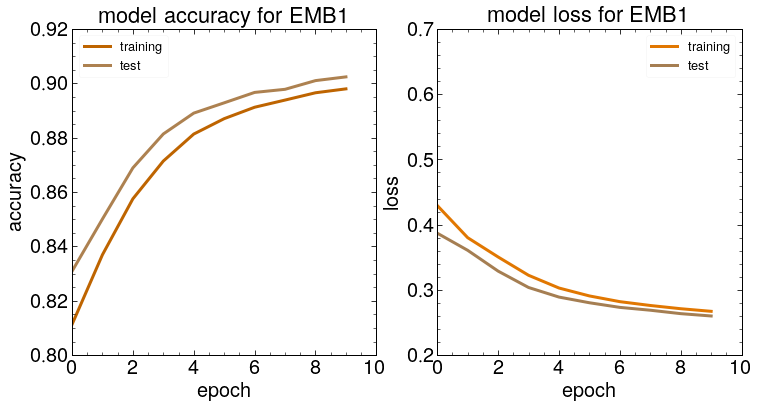

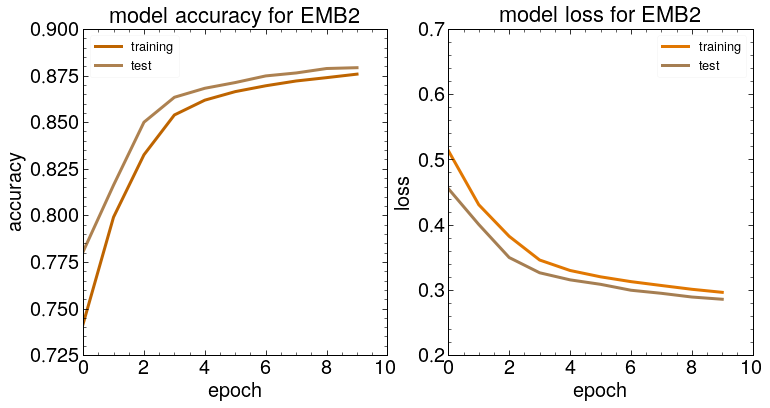

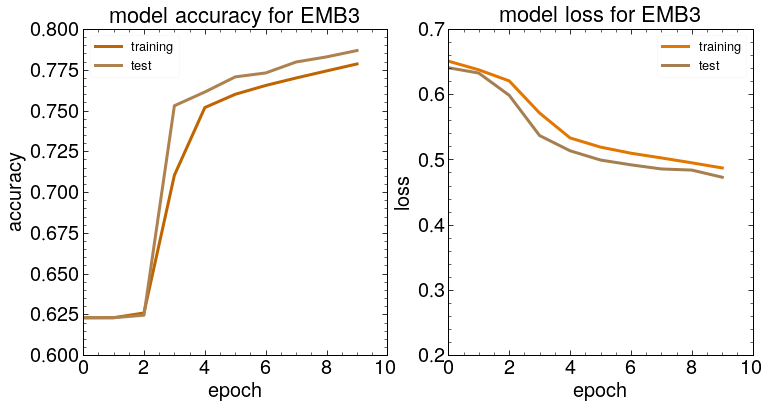

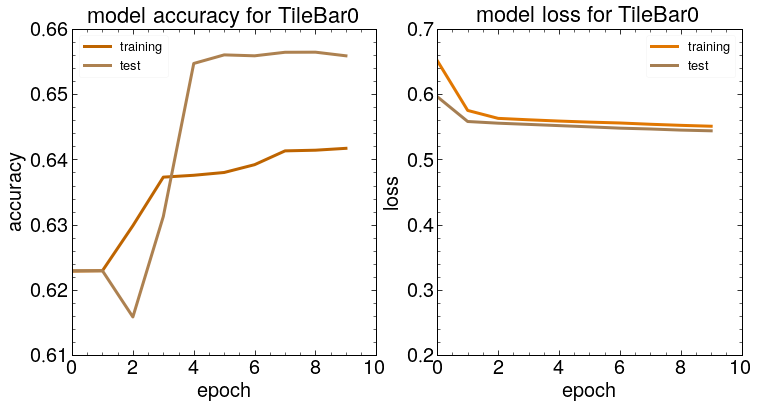

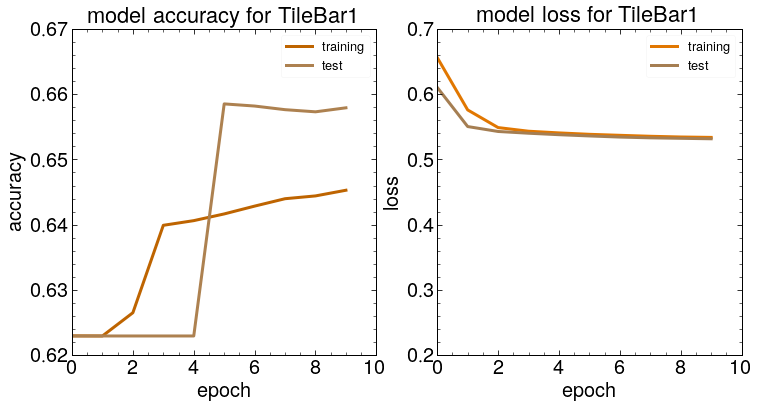

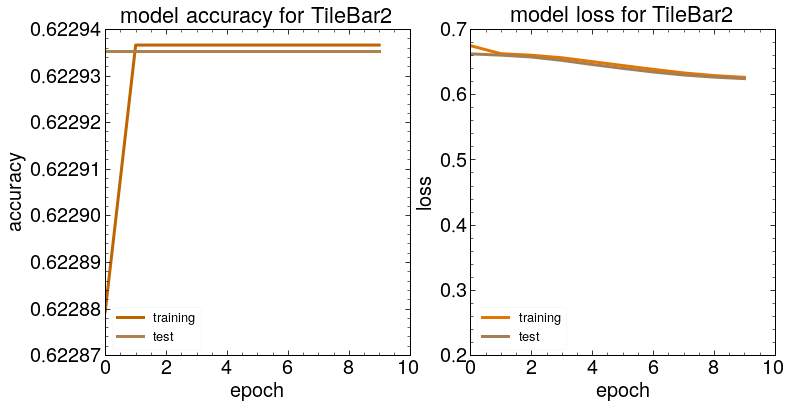

In [25]:
plotem(model_history) #baseline model - try to optimize next!?! Don't rerun!

In [35]:
# JUST EDIT THIS BLOCK and try to optimize for next few!
def my_nnmodel(number_pixels):
    model = Sequential()
    
    used_pixels = number_pixels
    if number_pixels < 128:
        used_pixels = 128
        
    model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(used_pixels, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(used_pixels, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(int(used_pixels/2), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['acc'])
    
    return model

# build the models layer by layer (ie assess layers separately)
models = {}
for layer in layers:
    npix = cell_shapes[layer][0]*cell_shapes[layer][1]
    models[layer] = my_nnmodel(npix)
    
#define dicts to store info
model_history = {}
model_performance = {}
model_scores = {}

for layer in layers:
    print('On layer ' + layer)
    
    # train+validate model
    model_history[layer] = models[layer].fit(pcells_merged[layer][pdata_merged.train],
                                             plabels[pdata_merged.train],
                                             validation_data = (pcells_merged[layer][pdata_merged.val],
                                                                plabels[pdata_merged.val]),
                                             epochs = 200, batch_size = 300, verbose = 1)
    
    model_history[layer] = model_history[layer].history
    
    # get overall performance metric
    model_performance[layer] = models[layer].evaluate(pcells_merged[layer][pdata_merged.test], 
                                                      plabels[pdata_merged.test], verbose = 0)
    
    # get network scores for the dataset
    model_scores[layer] = models[layer].predict(pcells_merged[layer])
    

On layer EMB1
Epoch 1/200
1633/1633 [==============================] - 8s 5ms/step - loss: 0.4931 - acc: 0.7956 - val_loss: 0.3825 - val_acc: 0.8348
Epoch 2/200
1633/1633 [==============================] - 7s 5ms/step - loss: 0.3794 - acc: 0.8367 - val_loss: 0.3484 - val_acc: 0.8592
Epoch 3/200
1633/1633 [==============================] - 8s 5ms/step - loss: 0.3425 - acc: 0.8607 - val_loss: 0.3092 - val_acc: 0.8779
Epoch 4/200
1633/1633 [==============================] - 7s 4ms/step - loss: 0.3129 - acc: 0.8760 - val_loss: 0.2900 - val_acc: 0.8880
Epoch 5/200
1633/1633 [==============================] - 7s 4ms/step - loss: 0.2940 - acc: 0.8855 - val_loss: 0.2792 - val_acc: 0.8935
Epoch 6/200
1633/1633 [==============================] - 7s 5ms/step - loss: 0.2858 - acc: 0.8894 - val_loss: 0.2726 - val_acc: 0.8963
Epoch 7/200
1633/1633 [==============================] - 7s 4ms/step - loss: 0.2795 - acc: 0.8928 - val_loss: 0.2717 - val_acc: 0.8961
Epoch 8/200
1633/1633 [==================

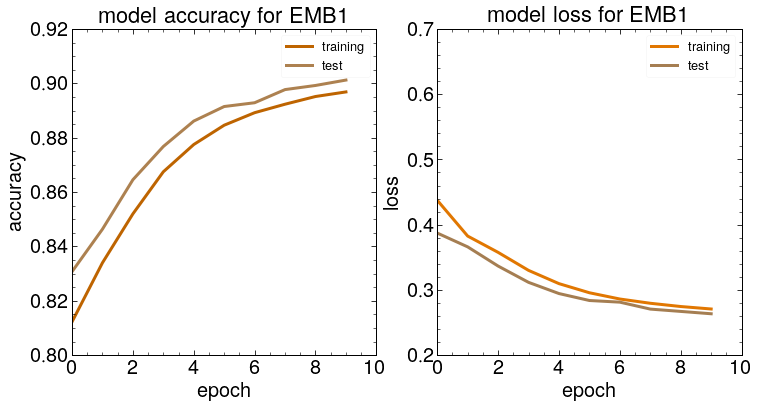

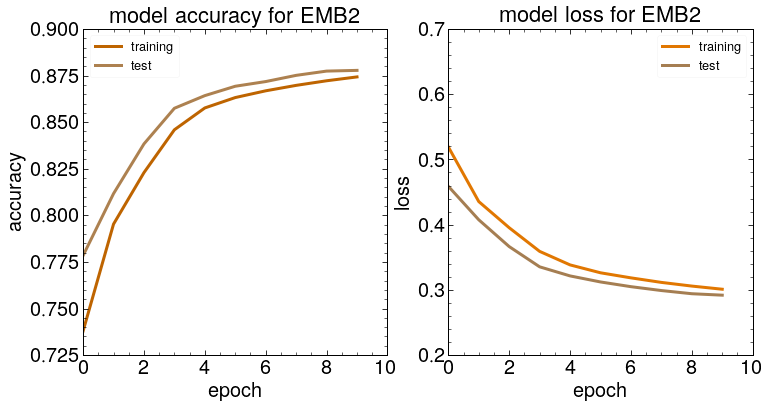

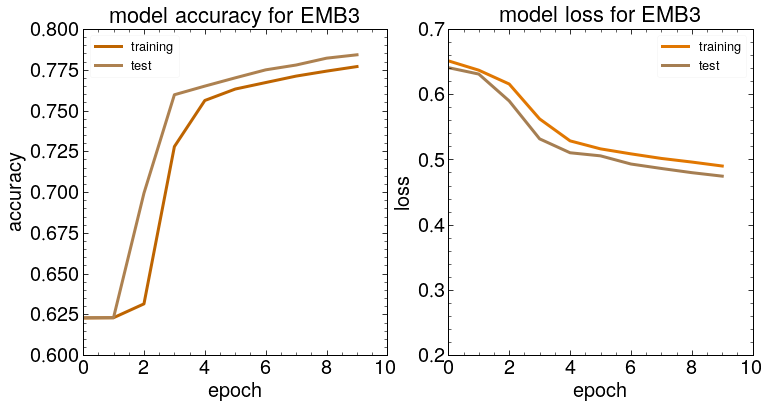

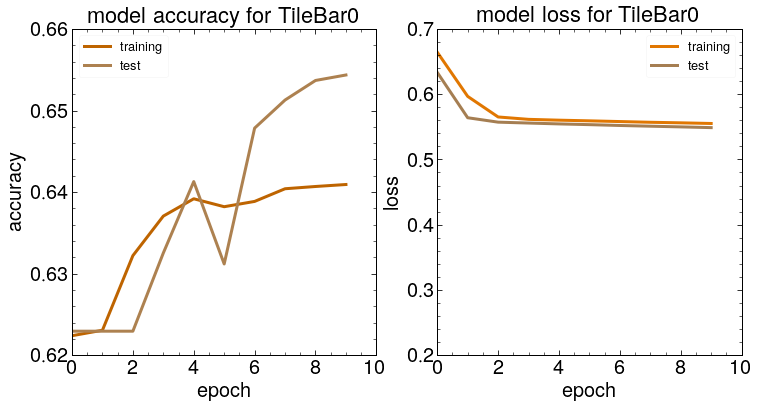

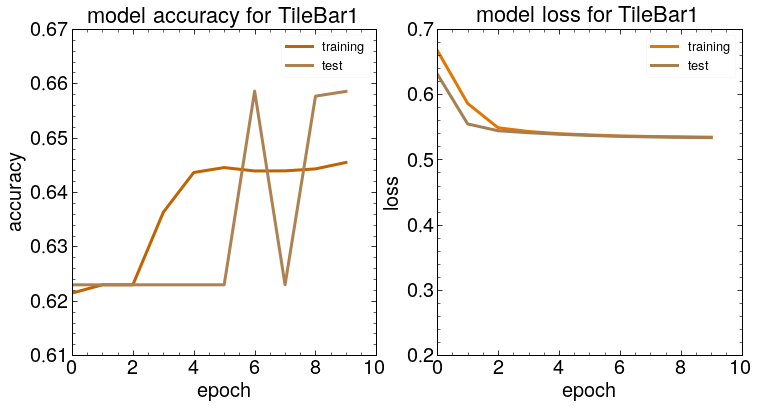

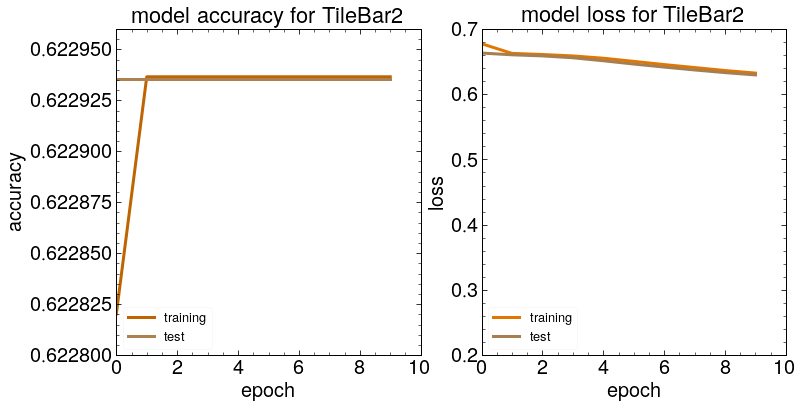

In [28]:
#try 1: keeping number of units same for all dense layers
plotem(model_history)

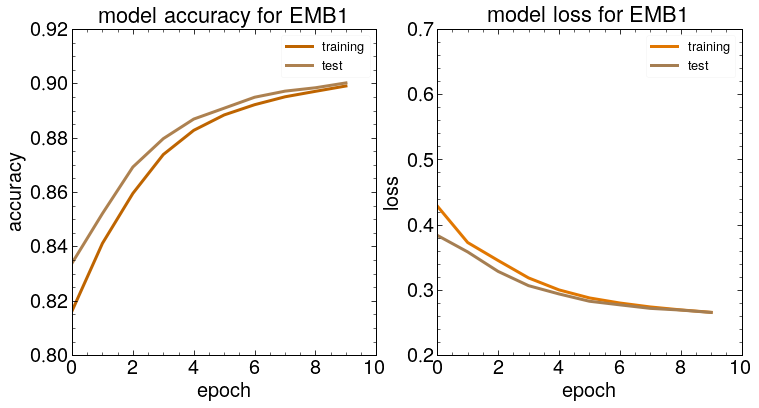

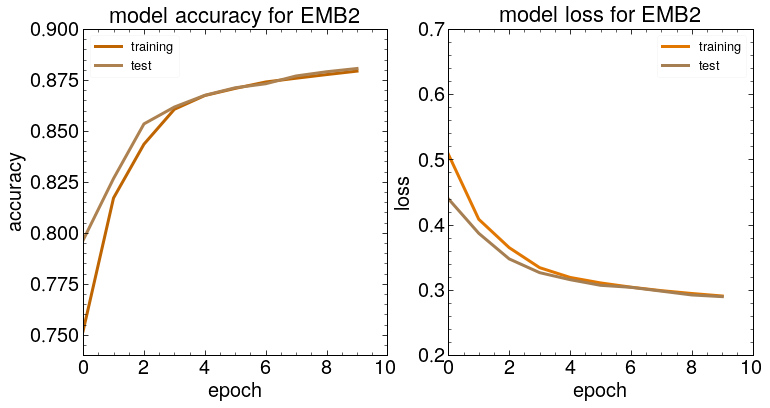

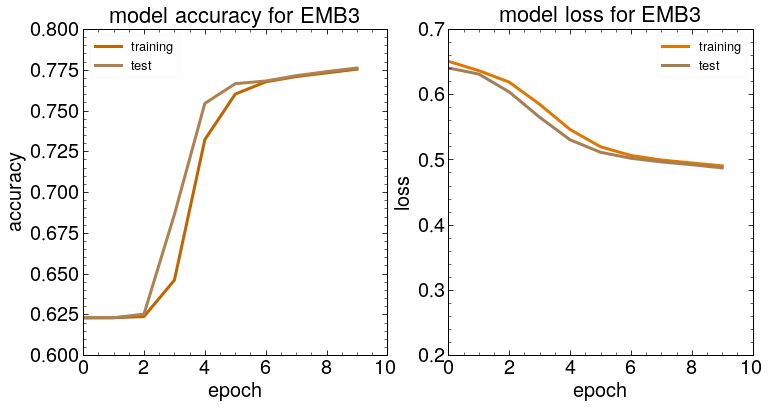

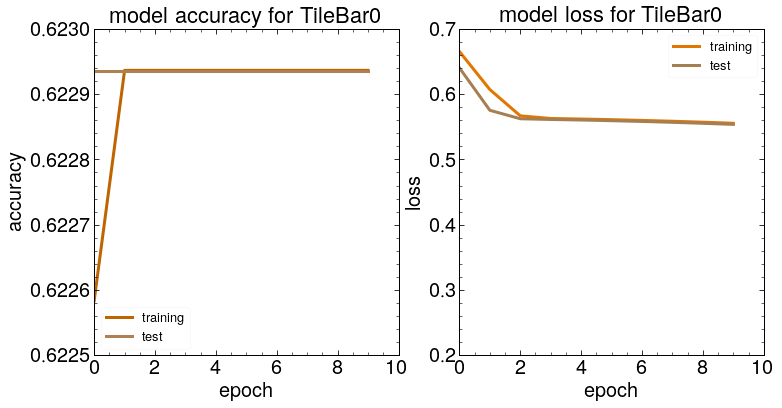

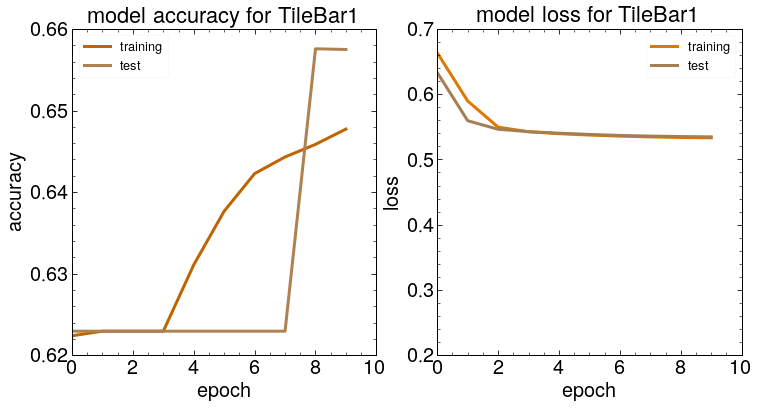

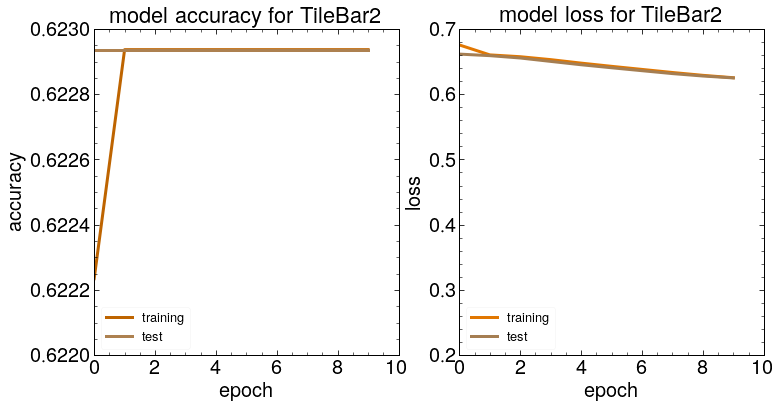

In [13]:
#try 2: keeping number of units same for all dense layers and NO dropout layers!
plotem(model_history) #also doesn't seem to change significantly... test is still ~ same as training so for this
#many epochs at least maybe dropout not needed

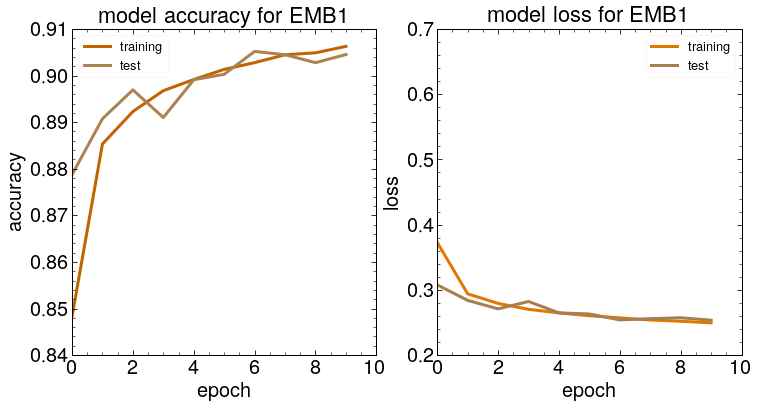

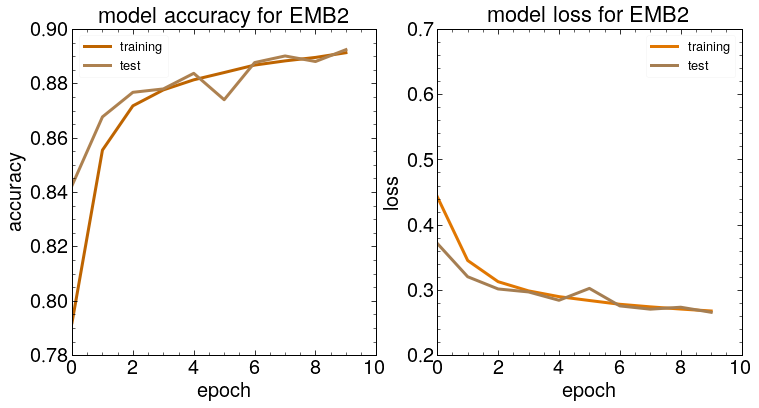

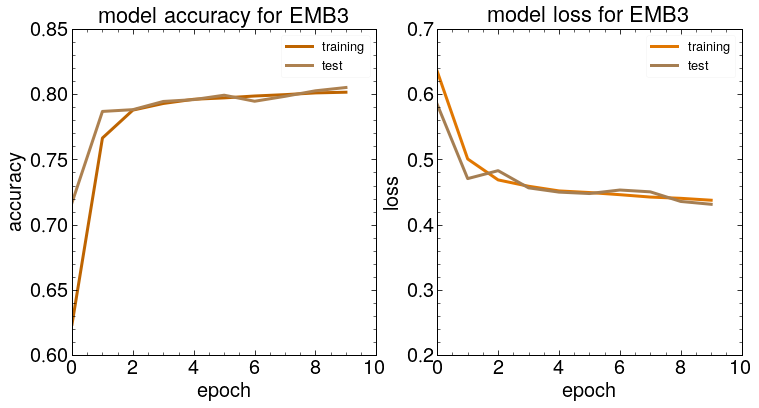

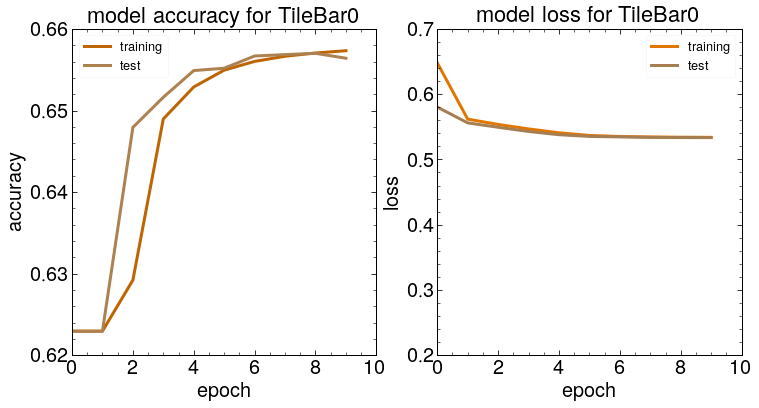

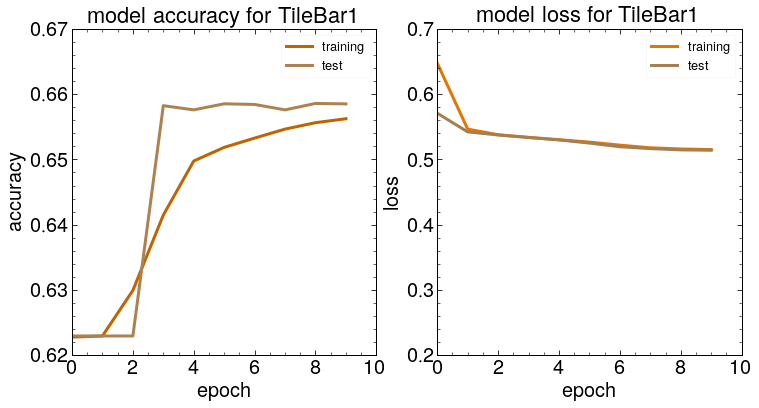

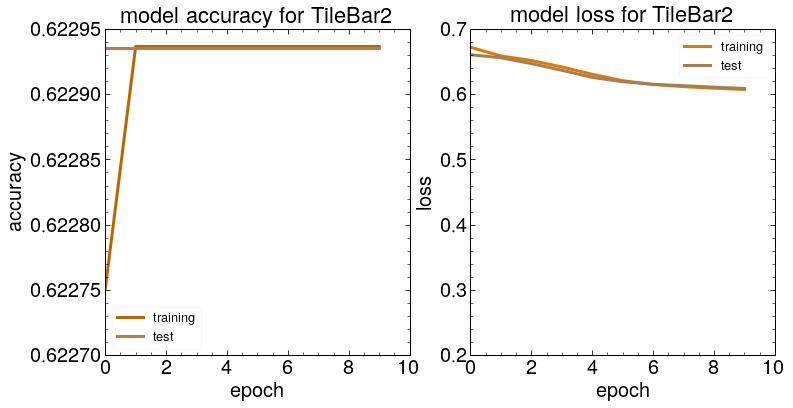

In [15]:
#try 3: equal units, no dropout, increase # of dense layers
plotem(model_history)

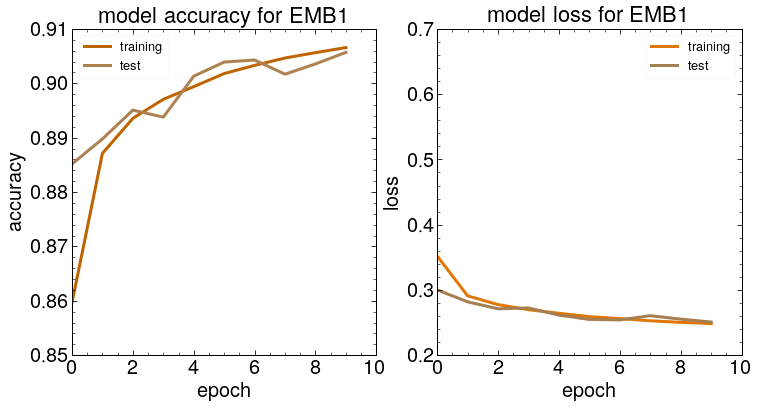

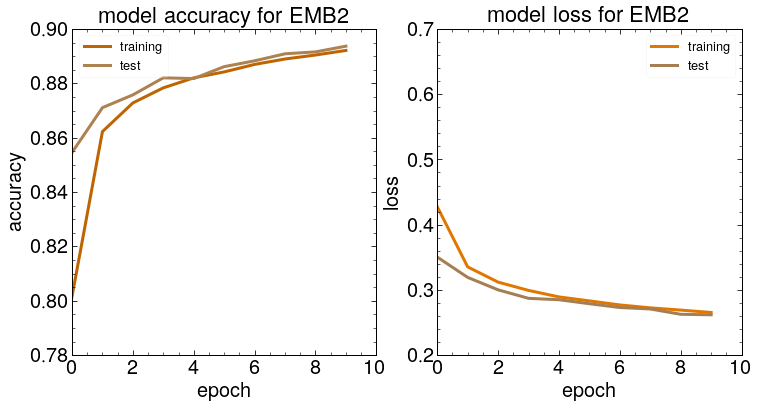

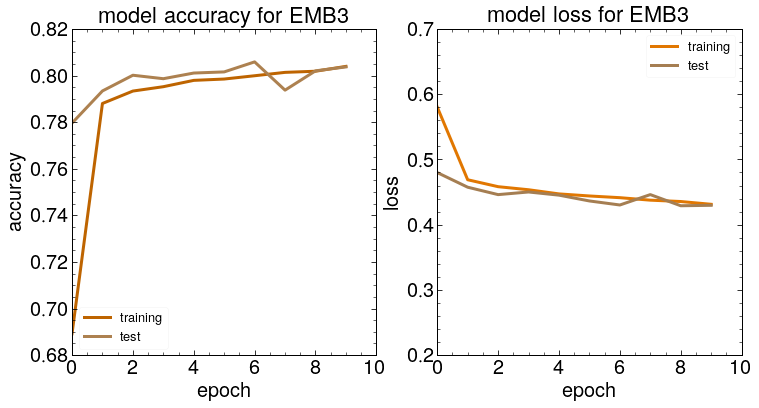

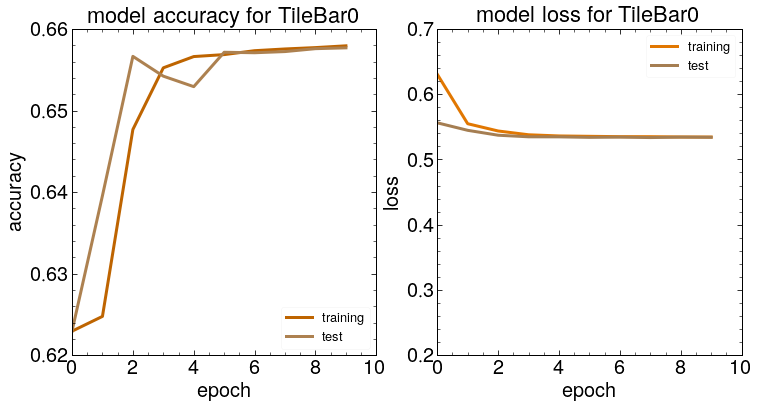

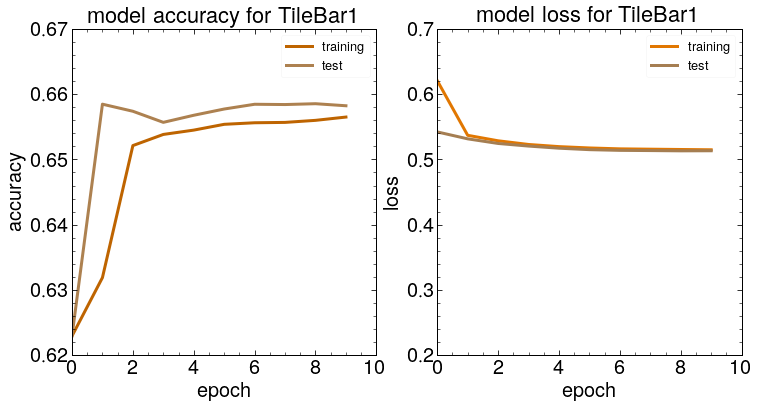

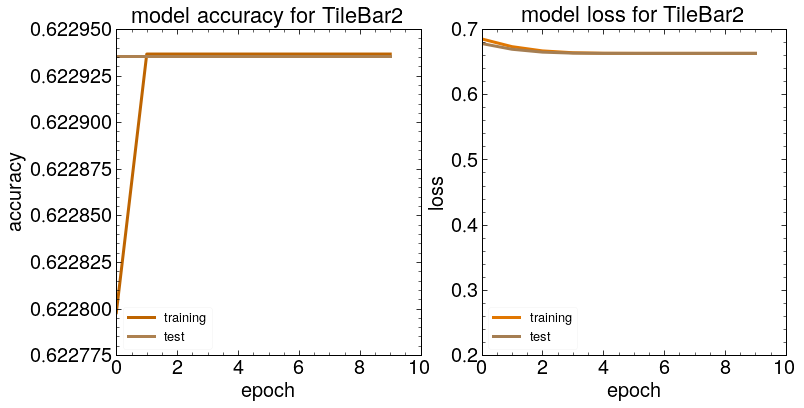

In [17]:
#try 4: equal units,even more dense layers, couple of dropout layers
plotem(model_history)

In [18]:
npix

8

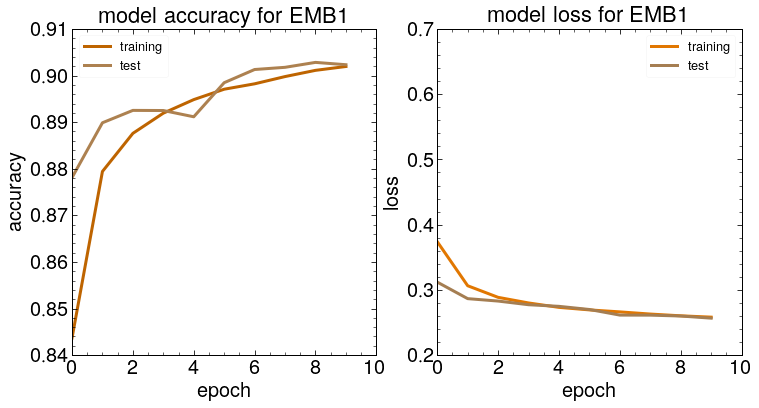

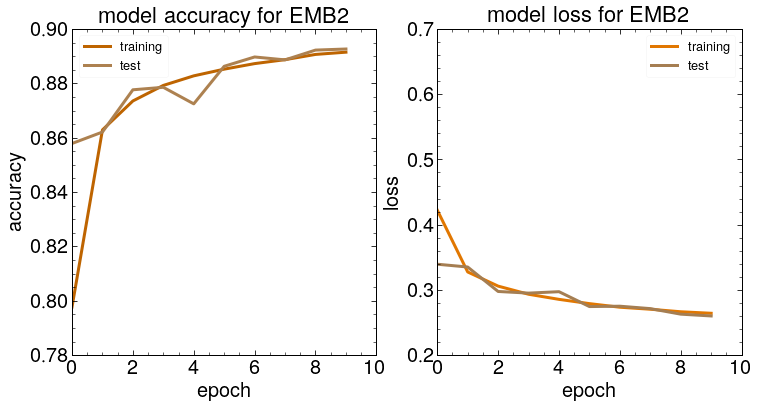

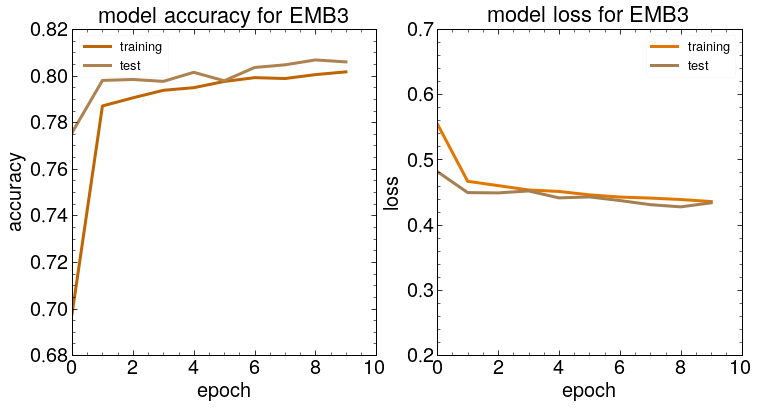

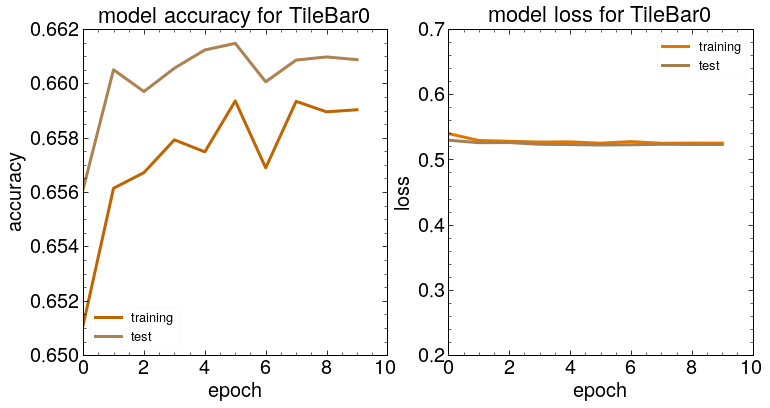

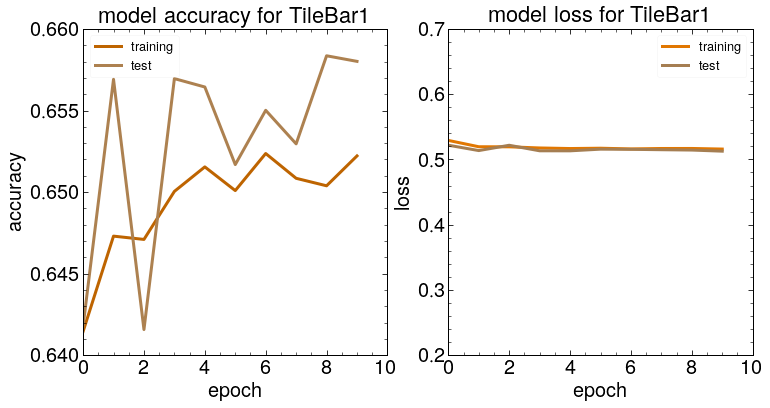

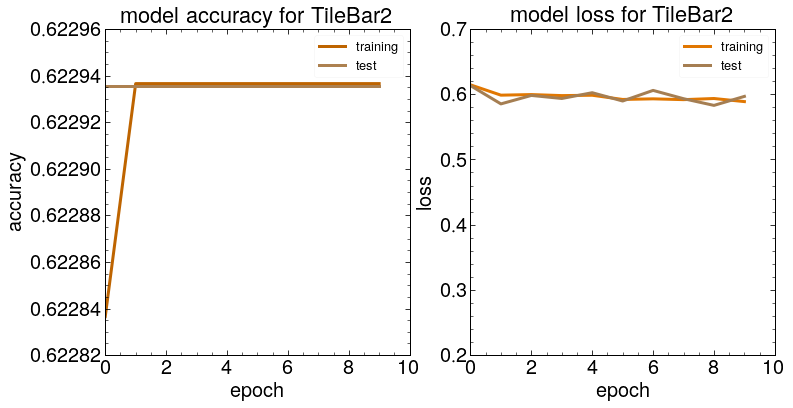

In [21]:
#try 4: equal units,even more dense layers, couple of dropout layers, standard number of units (600) instead of 
plotem(model_history) #npix (bc it needs to be more than the highest.. too high for the smaller ones? I just feel
#like 8 is too few for the last ones lol). This is not an improvement lol

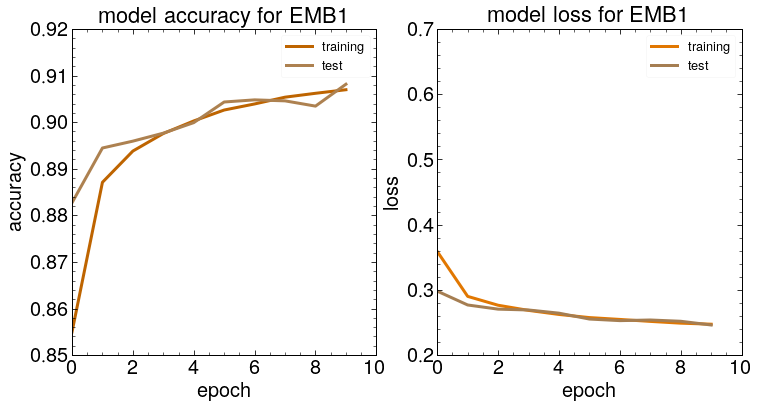

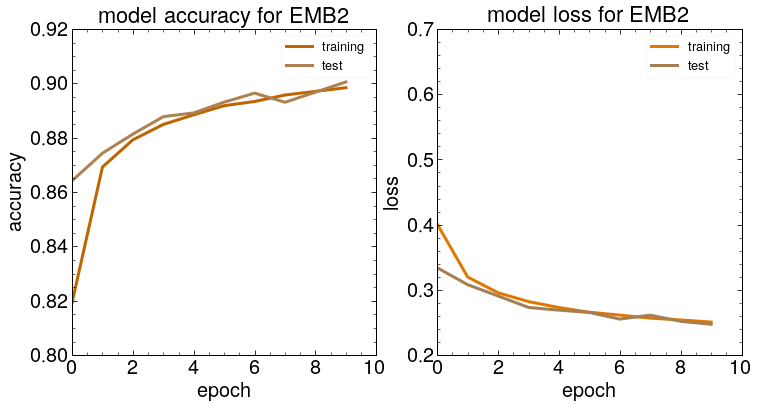

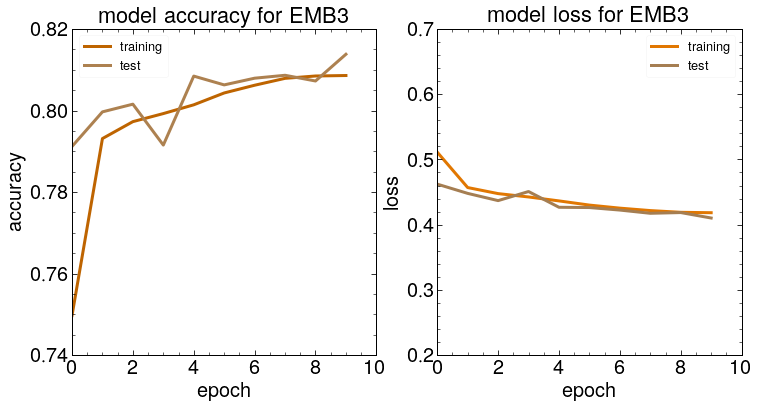

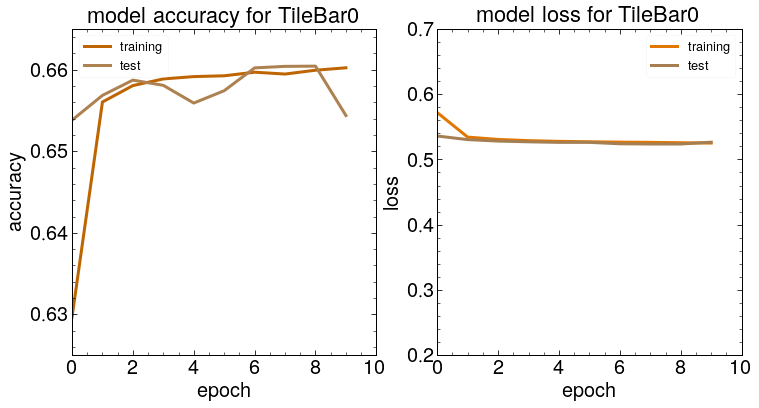

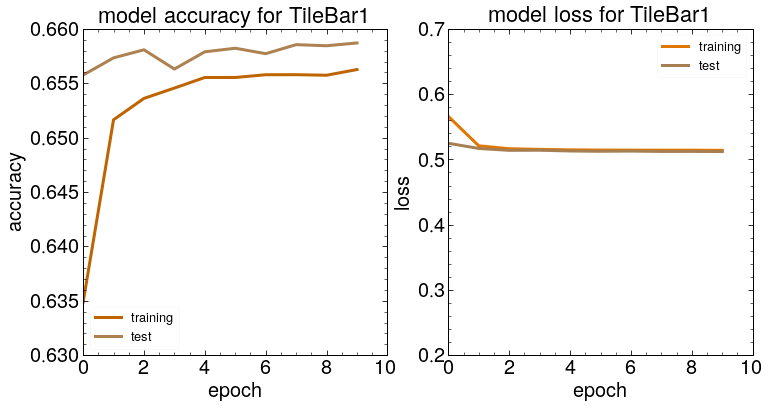

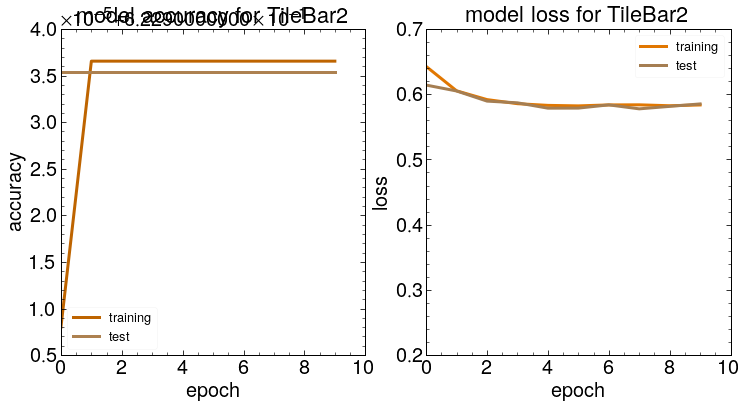

In [23]:
#try 5: few less layers, more units unless the number pixels is way less, then 64, couple of dropout layers
plotem(model_history)

Alright well with all of this I have concluded that I can't make it any better easily. Guess its not important to make it perfect but its tempting and part of me just wants to knowwww what would perfect it I wanna tack on a MCMC to figure out what's best but obviously that's not necessary lol

Area under curve for EMB1: 0.9646566440663447
Area under curve for EMB2: 0.9662501094549094
Area under curve for EMB3: 0.8726171415930213
Area under curve for TileBar0: 0.716671841075227
Area under curve for TileBar1: 0.7235866091163906
Area under curve for TileBar2: 0.6402389627315144


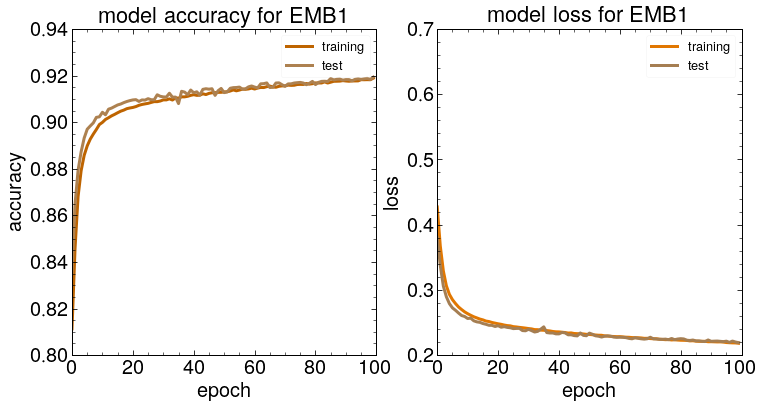

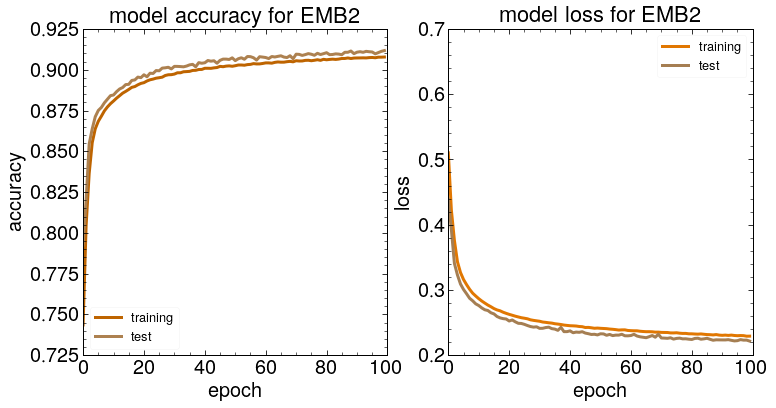

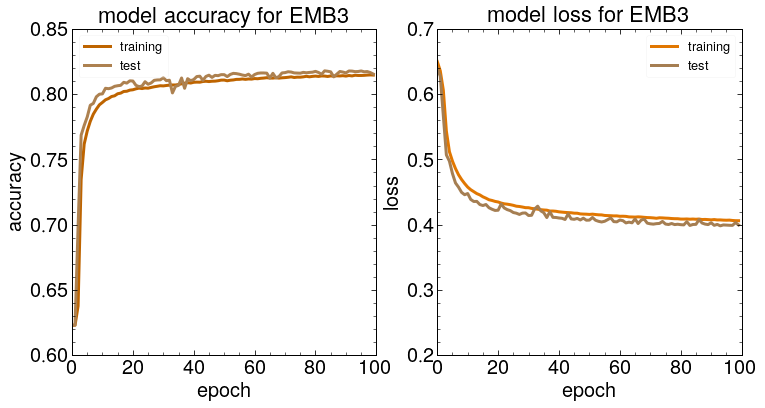

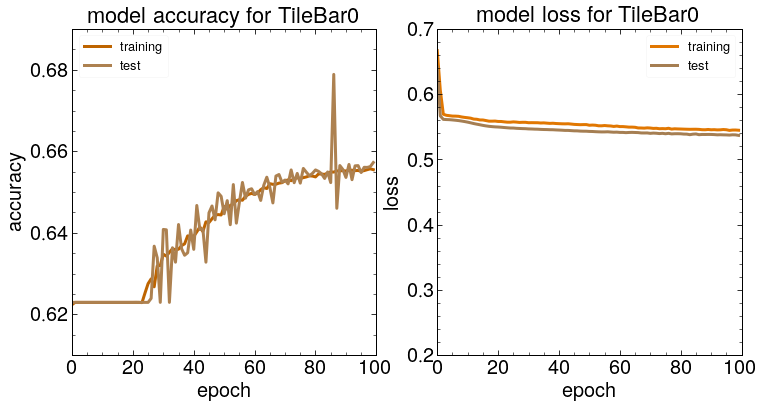

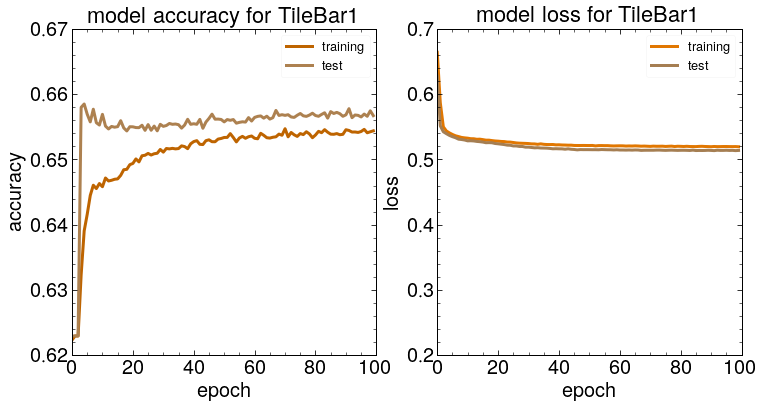

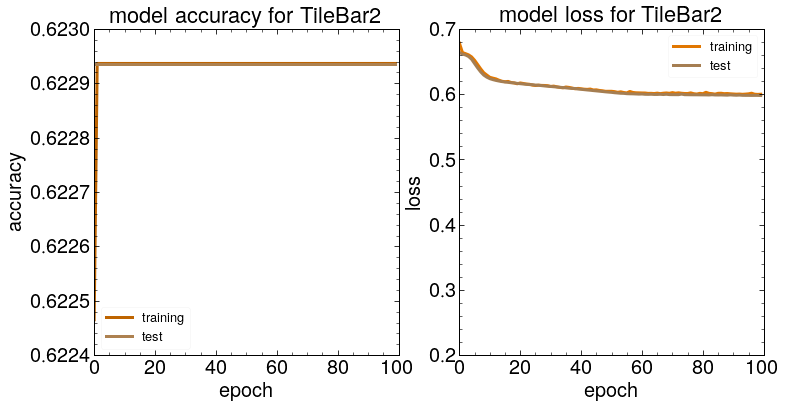

In [34]:
#return to his version (with a couple extra layers cmon couldnt hurt) okay apparently 
plotem(model_history)

Area under curve for EMB1: 0.9680852009605828
Area under curve for EMB2: 0.9687768427301687
Area under curve for EMB3: 0.8796927866588448
Area under curve for TileBar0: 0.7882309741801663
Area under curve for TileBar1: 0.7232620759807403
Area under curve for TileBar2: 0.6402357003636133


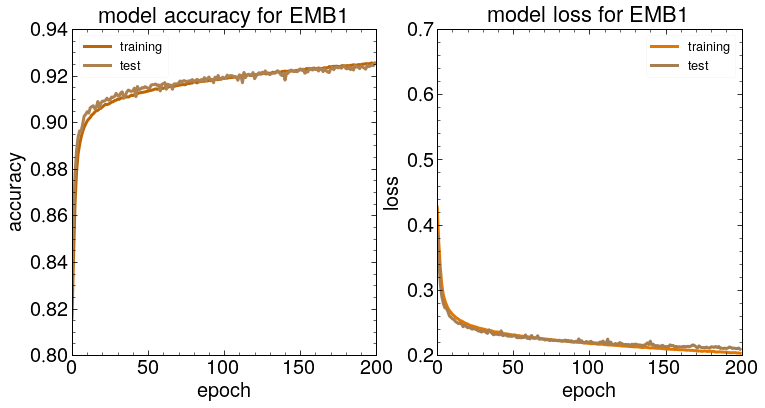

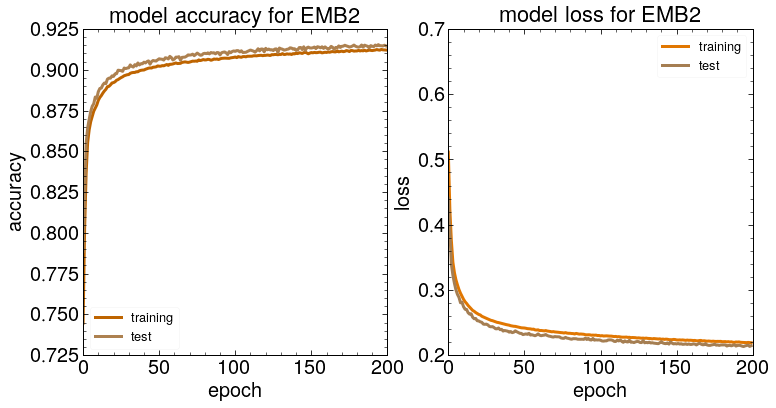

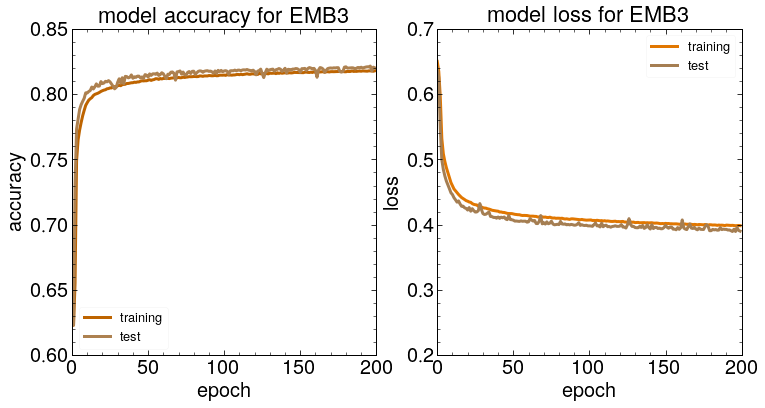

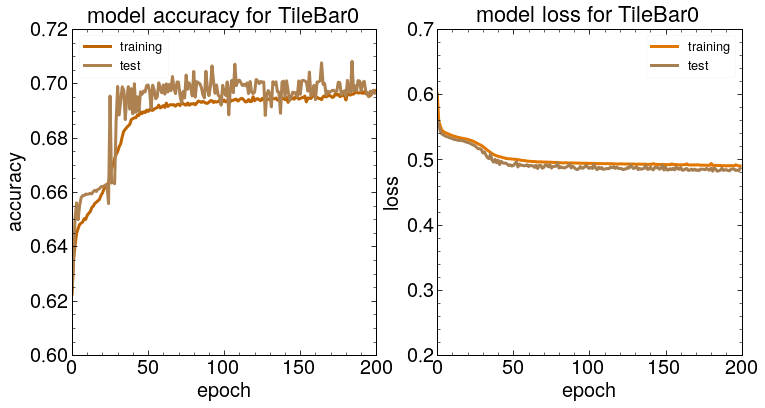

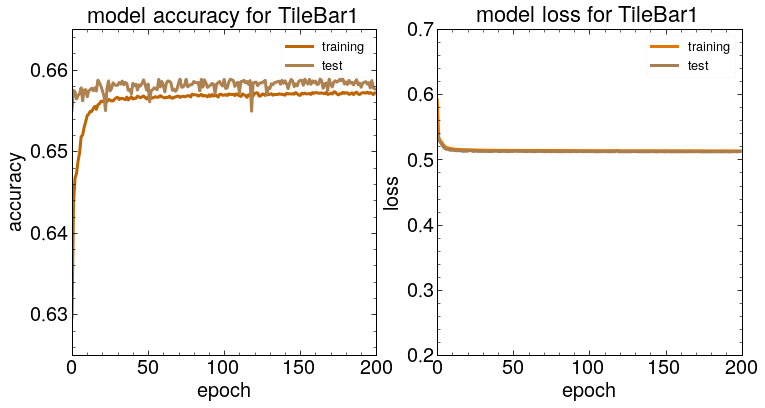

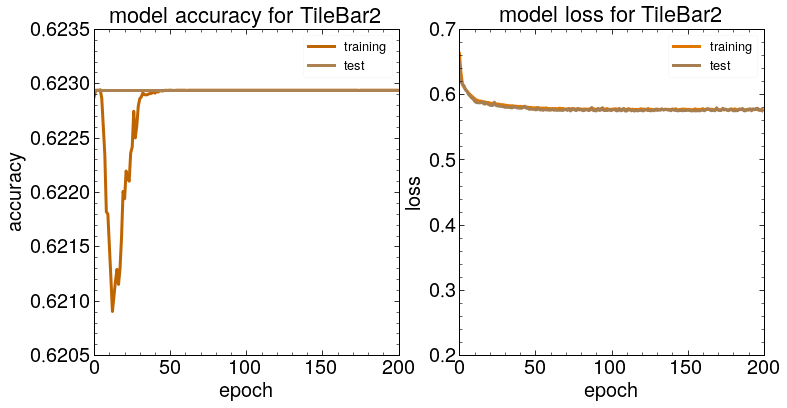

In [37]:
#return to his version with a couple extra layers and also that 128 pixel provision since I'm curious oh and 200 epoch
plotem(model_history)

In [35]:
# next concatenate/merge them

def merged_model():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  #having the (x1) in brackets at the end like this is another way of 
    x1 = Dropout(0.2)(x1)                 #concatenating/adding layers to x1! basically instead of the model.Add()
    x1 = Flatten()(x1)                    #method from before can just do this! Basically the layer line acts as
    x1 = Dense(128, activation='relu')(x1)#a 'functor' (acts as a function) so the thing at the end in brackets is
    x1 = Dropout(0.2)(x1)                 #effectively being called! okay!
    x1 = Dense(128, activation='relu')(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu')(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu')(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu')(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu')(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

In [14]:
mergedm = merged_model()
#this one has original number of dense and dropout layers
history_all = mergedm.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=100, batch_size=300, verbose=1)

scores_all = mergedm.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

Epoch 1/100
1633/1633 [==============================] - 20s 10ms/step - loss: 0.3452 - accuracy: 0.8502 - val_loss: 0.2271 - val_accuracy: 0.9123
Epoch 2/100
1633/1633 [==============================] - 14s 9ms/step - loss: 0.2247 - accuracy: 0.9137 - val_loss: 0.2074 - val_accuracy: 0.9211
Epoch 3/100
1633/1633 [==============================] - 14s 9ms/step - loss: 0.2085 - accuracy: 0.9218 - val_loss: 0.1958 - val_accuracy: 0.9277
Epoch 4/100
1633/1633 [==============================] - 14s 8ms/step - loss: 0.2005 - accuracy: 0.9252 - val_loss: 0.1927 - val_accuracy: 0.9287
Epoch 5/100
1633/1633 [==============================] - 14s 8ms/step - loss: 0.1966 - accuracy: 0.9270 - val_loss: 0.1886 - val_accuracy: 0.9310
Epoch 6/100
1633/1633 [==============================] - 14s 8ms/step - loss: 0.1924 - accuracy: 0.9285 - val_loss: 0.1882 - val_accuracy: 0.9313
Epoch 7/100
1633/1633 [==============================] - 13s 8ms/step - loss: 0.1897 - accuracy: 0.9298 - val_loss: 0.1839 

In [15]:
roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

Area under curve for CNN All 0.9845578838086078


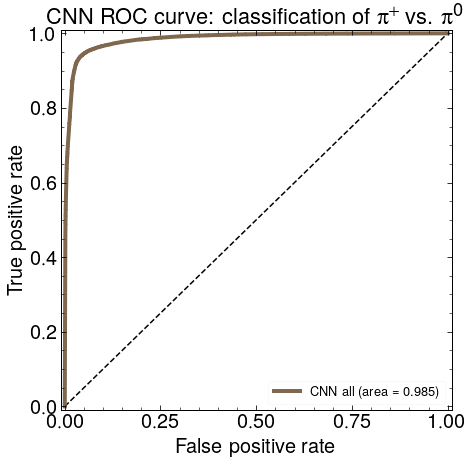

In [16]:
fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

Area under curve: 0.9845578838086078


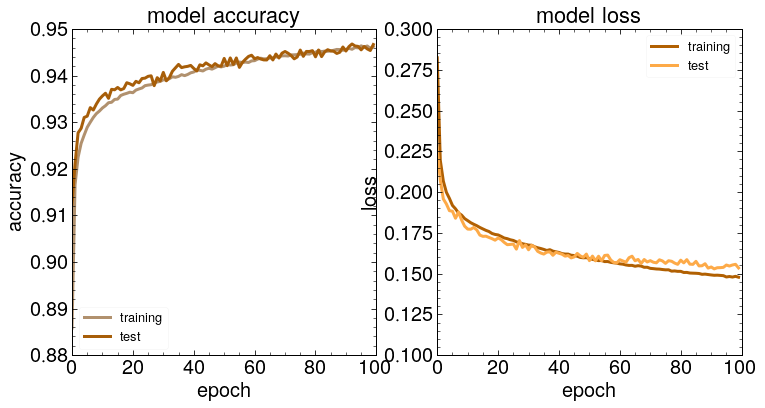

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,100)
ax1.plot(history_all.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_all.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,100)
ax2.set_ylim(.1, .3)
ax2.plot(history_all.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_all.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.legend()


roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(
plabels[pdata_merged.test][:,1],
scores_all[pdata_merged.test,1],
drop_intermediate=False,
)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve: ' + str(roc_auc_all))

Epoch 1/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.3288 - accuracy: 0.8588 - val_loss: 0.2169 - val_accuracy: 0.9175
Epoch 2/300
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2148 - accuracy: 0.9181 - val_loss: 0.2032 - val_accuracy: 0.9245
Epoch 3/300
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2056 - accuracy: 0.9222 - val_loss: 0.2013 - val_accuracy: 0.9247
Epoch 4/300
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2001 - accuracy: 0.9249 - val_loss: 0.1888 - val_accuracy: 0.9307
Epoch 5/300
1633/1633 [==============================] - 17s 11ms/step - loss: 0.1960 - accuracy: 0.9273 - val_loss: 0.1941 - val_accuracy: 0.9285
Epoch 6/300
1633/1633 [==============================] - 17s 11ms/step - loss: 0.1926 - accuracy: 0.9283 - val_loss: 0.1851 - val_accuracy: 0.9330
Epoch 7/300
1633/1633 [==============================] - 18s 11ms/step - loss: 0.1897 - accuracy: 0.9297 - val_loss: 0

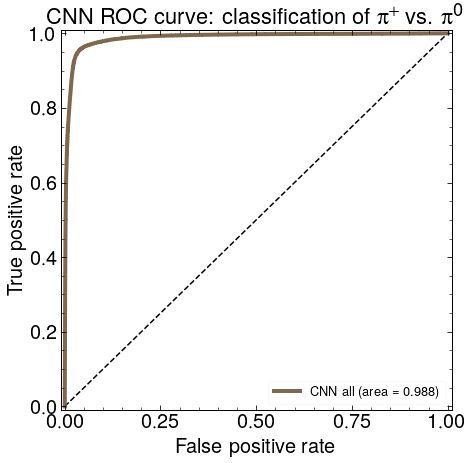

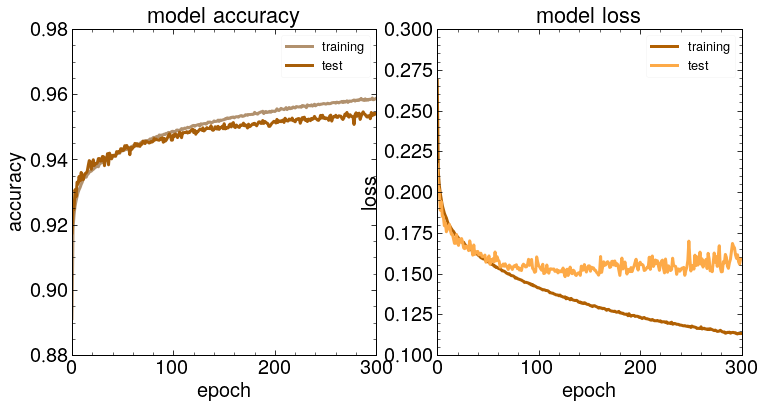

In [34]:
mergedm = merged_model()
#rerun for more dense layers, see what happens. seems to improve ever so slightly? not significantly enough tho
history_all = mergedm.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=300, batch_size=300, verbose=1)

scores_all = mergedm.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,300)
ax1.plot(history_all.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_all.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,300)
ax2.set_ylim(.1, .3)
ax2.plot(history_all.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_all.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
plt.legend()



Epoch 1/300
1633/1633 [==============================] - 21s 12ms/step - loss: 0.3335 - accuracy: 0.8521 - val_loss: 0.2176 - val_accuracy: 0.9150
Epoch 2/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2205 - accuracy: 0.9144 - val_loss: 0.2128 - val_accuracy: 0.9189
Epoch 3/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2104 - accuracy: 0.9194 - val_loss: 0.1956 - val_accuracy: 0.9273
Epoch 4/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2055 - accuracy: 0.9223 - val_loss: 0.1939 - val_accuracy: 0.9290
Epoch 5/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.1999 - accuracy: 0.9250 - val_loss: 0.1899 - val_accuracy: 0.9312
Epoch 6/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.1983 - accuracy: 0.9262 - val_loss: 0.1878 - val_accuracy: 0.9312
Epoch 7/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.1934 - accuracy: 0.9285 - val_loss: 0

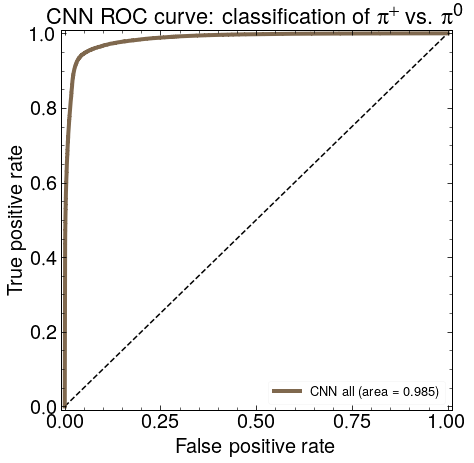

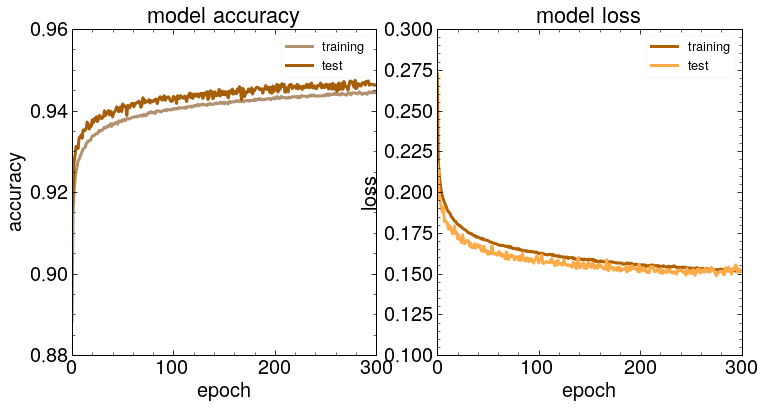

In [36]:
mergedm = merged_model()
#same number of increased dense layers, now add dropout since the above was overfitting!
history_all = mergedm.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=300, batch_size=300, verbose=1)

scores_all = mergedm.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,300)
ax1.plot(history_all.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_all.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,300)
ax2.set_ylim(.1, .3)
ax2.plot(history_all.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_all.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #hmm so doesn't get as good as the overfit one, but that does work to prevent overfitting
plt.legend()

In [11]:
from tensorflow.keras import regularizers


In [37]:
#try regulariszation!

from tensorflow.keras import regularizers

### idk if this'll help but reduces learning rate over time, could help????
#lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
 #   0.001,
  #  decay_steps=STEPS_PER_EPOCH*1000,
   # decay_rate=1,
    #staircase=False)

#def get_optimizer():
 #   return tf.keras.optimizers.Adam(lr_schedule)
###

def merged_model_reg():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  #having the (x1) in brackets at the end like this is another way of 
    x1 = Dropout(0.2)(x1)                 #concatenating/adding layers to x1! basically instead of the model.Add()
    x1 = Flatten()(x1)                    #method from before can just do this! Basically the layer line acts as
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)#a 'functor' (acts as a function) so the thing at the end in brackets is
    #x1 = Dropout(0.2)(x1)                 #effectively being called! okay!
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)
    #x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)
    #x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)
    #x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    #x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    #x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)
    #x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)
    #x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    #x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    #x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)
    #x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)
    #x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model


Epoch 1/300
1633/1633 [==============================] - 20s 12ms/step - loss: 0.6697 - accuracy: 0.8337 - val_loss: 0.3384 - val_accuracy: 0.8763
Epoch 2/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.3156 - accuracy: 0.8900 - val_loss: 0.3059 - val_accuracy: 0.8945
Epoch 3/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.3025 - accuracy: 0.8937 - val_loss: 0.2939 - val_accuracy: 0.9006
Epoch 4/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2956 - accuracy: 0.8962 - val_loss: 0.2855 - val_accuracy: 0.9014
Epoch 5/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.2900 - accuracy: 0.8991 - val_loss: 0.2776 - val_accuracy: 0.9036
Epoch 6/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.2895 - accuracy: 0.8983 - val_loss: 0.2983 - val_accuracy: 0.8942
Epoch 7/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2881 - accuracy: 0.8992 - val_loss: 0

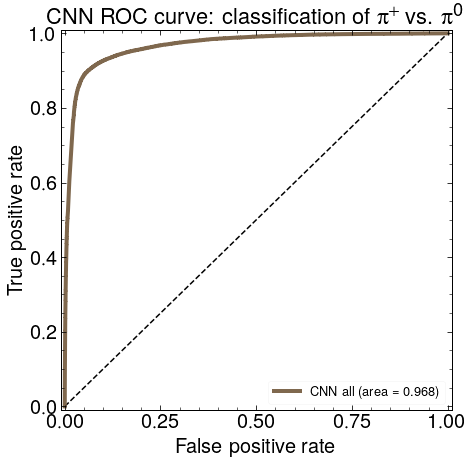

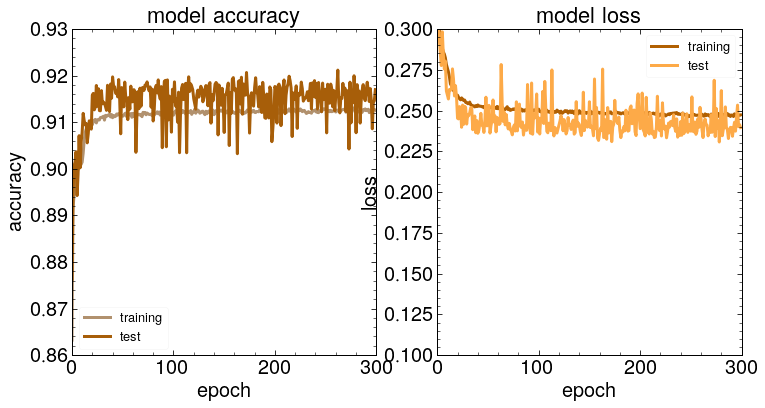

In [41]:
mergedmr = merged_model_reg()
#same number of increased dense layers, now use regularization instead of dropout
history_reg = mergedmr.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=300, batch_size=300, verbose=1)

scores_all = mergedmr.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,300)
ax1.plot(history_reg.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_reg.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,300)
ax2.set_ylim(.1, .3)
ax2.plot(history_reg.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_reg.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #hmm so doesn't get as good as the overfit one, but that does work to prevent overfitting
plt.legend()

#regularization_loss=tf.add_n(mergedmr.losses) #not sure what this does

In [42]:
#make one with regularization and dropout. 
#there are lots of options for playing with regularization!!!!!
#TRY: different l2 values, having the regularizer on some layers but not others, having more/less dense and dropout layers on topof these, putting dropoout/regularizers at the end instead of within the 6 inputs.

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  #having the (x1) in brackets at the end like this is another way of 
    x1 = Dropout(0.2)(x1)                 #concatenating/adding layers to x1! basically instead of the model.Add()
    x1 = Flatten()(x1)                    #method from before can just do this! Basically the layer line acts as
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)#a 'functor' (acts as a function) so the thing at the end in brackets is
    x1 = Dropout(0.2)(x1)                 #effectively being called! okay!
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model


Epoch 1/300
1633/1633 [==============================] - 24s 14ms/step - loss: 0.6724 - accuracy: 0.8253 - val_loss: 0.3383 - val_accuracy: 0.8795
Epoch 2/300
1633/1633 [==============================] - 22s 13ms/step - loss: 0.3394 - accuracy: 0.8768 - val_loss: 0.3169 - val_accuracy: 0.8852
Epoch 3/300
1633/1633 [==============================] - 22s 13ms/step - loss: 0.3193 - accuracy: 0.8866 - val_loss: 0.3059 - val_accuracy: 0.8917
Epoch 4/300
1633/1633 [==============================] - 22s 13ms/step - loss: 0.3133 - accuracy: 0.8888 - val_loss: 0.3281 - val_accuracy: 0.8835
Epoch 5/300
1633/1633 [==============================] - 22s 13ms/step - loss: 0.3093 - accuracy: 0.8906 - val_loss: 0.2959 - val_accuracy: 0.8963
Epoch 6/300
1633/1633 [==============================] - 21s 13ms/step - loss: 0.3072 - accuracy: 0.8912 - val_loss: 0.2893 - val_accuracy: 0.9019
Epoch 7/300
1633/1633 [==============================] - 21s 13ms/step - loss: 0.3028 - accuracy: 0.8922 - val_loss: 0

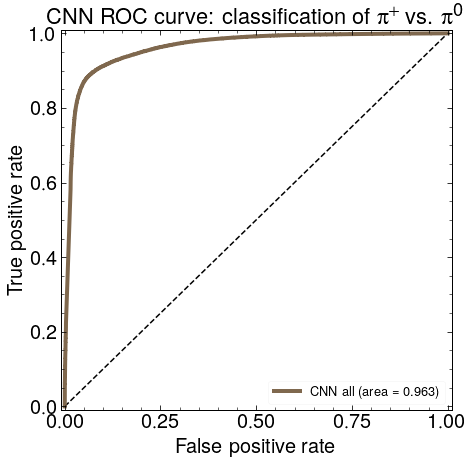

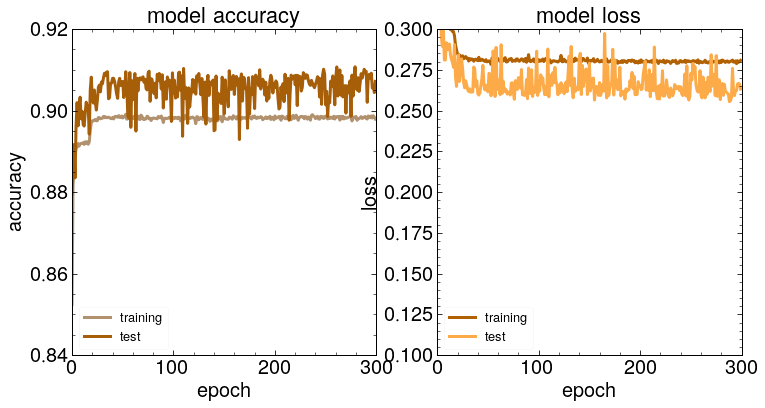

In [43]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, now use regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=300, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,300)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,300)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #hmm so doesn't get as good as the overfit one, but that does work to prevent overfitting
plt.legend()

In [12]:
#continue reg/drop combos:
#TRY: different l2 values, having the regularizer on some layers but not others, having more/less dense and dropout layers on topof these, putting dropoout/regularizers at the end instead of within the 6 inputs.

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu',data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    #x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.2)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    #x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    #x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
    #x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    #x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    #x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
    #x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    #x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model


Epoch 1/200
1633/1633 [==============================] - 20s 11ms/step - loss: 0.5662 - accuracy: 0.8398 - val_loss: 0.2483 - val_accuracy: 0.9063
Epoch 2/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2478 - accuracy: 0.9065 - val_loss: 0.2271 - val_accuracy: 0.9140
Epoch 3/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2255 - accuracy: 0.9158 - val_loss: 0.2206 - val_accuracy: 0.9199
Epoch 4/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2155 - accuracy: 0.9210 - val_loss: 0.2091 - val_accuracy: 0.9242
Epoch 5/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2093 - accuracy: 0.9247 - val_loss: 0.2006 - val_accuracy: 0.9308
Epoch 6/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2046 - accuracy: 0.9267 - val_loss: 0.1974 - val_accuracy: 0.9299
Epoch 7/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2025 - accuracy: 0.9273 - val_loss: 0

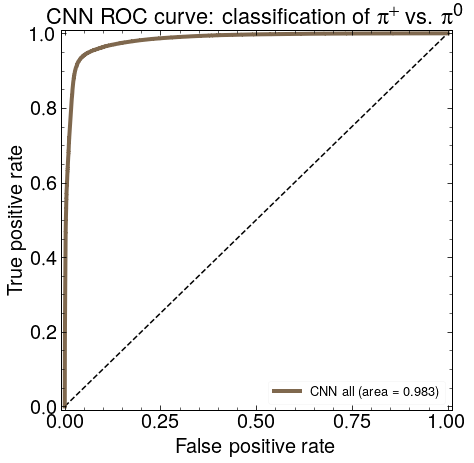

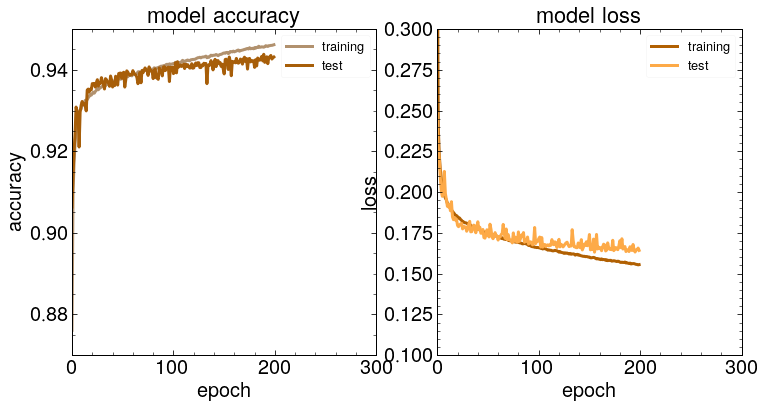

In [14]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,300)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,300)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #a bit better at first but still overfits - diverges!
plt.legend()

In [11]:
#try reg/drop at the beginning instead of at the end for each 

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x1)
    x1 = Dropout(0.2)(x1)                 
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.2)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.2)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.001),data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu')(x3)
    #x3 = Dropout(0.2)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.2)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu')(x5)
    #x5 = Dropout(0.2)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.2)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model


In [12]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,200)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,200)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #hmm so doesn't get as good 
plt.legend()

Epoch 1/200
1633/1633 [==============================] - 29s 13ms/step - loss: 0.4489 - accuracy: 0.8380 - val_loss: 0.2700 - val_accuracy: 0.9048
Epoch 2/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2752 - accuracy: 0.9015 - val_loss: 0.2500 - val_accuracy: 0.9104
Epoch 3/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2650 - accuracy: 0.9044 - val_loss: 0.2518 - val_accuracy: 0.9120
Epoch 4/200
1633/1633 [==============================] - 19s 11ms/step - loss: 0.2576 - accuracy: 0.9074 - val_loss: 0.2409 - val_accuracy: 0.9145
Epoch 5/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2562 - accuracy: 0.9074 - val_loss: 0.2472 - val_accuracy: 0.9108
Epoch 6/200
1633/1633 [==============================] - 19s 11ms/step - loss: 0.2528 - accuracy: 0.9095 - val_loss: 0.2395 - val_accuracy: 0.9156
Epoch 7/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2515 - accuracy: 0.9102 - val_loss: 0

NameError: name 'roc_curve' is not defined

In [13]:
from sklearn.metrics import roc_curve, auc

Area under curve for CNN All 0.9629405081686675


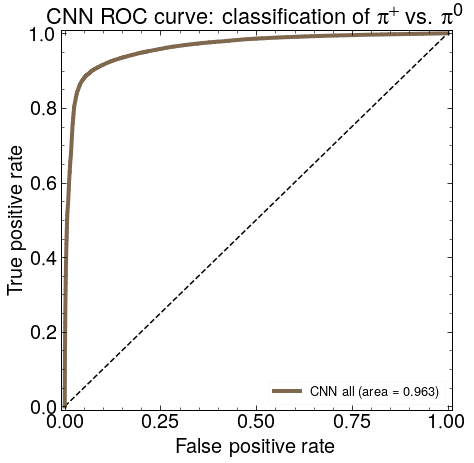

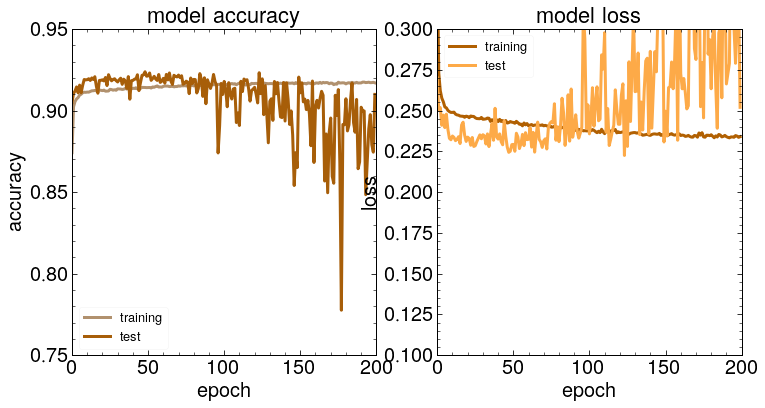

In [14]:
roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,200)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,200)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #hmm so doesn't get as good 
plt.legend()

In [15]:
#TRY: smaller l2 and dropout values?

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.1)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model


Epoch 1/140
1633/1633 [==============================] - 23s 13ms/step - loss: 0.3913 - accuracy: 0.8551 - val_loss: 0.2721 - val_accuracy: 0.9036
Epoch 2/140
1633/1633 [==============================] - 21s 13ms/step - loss: 0.2522 - accuracy: 0.9121 - val_loss: 0.2279 - val_accuracy: 0.9240
Epoch 3/140
1633/1633 [==============================] - 20s 13ms/step - loss: 0.2378 - accuracy: 0.9178 - val_loss: 0.2338 - val_accuracy: 0.9208
Epoch 4/140
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2322 - accuracy: 0.9204 - val_loss: 0.2210 - val_accuracy: 0.9251
Epoch 5/140
1633/1633 [==============================] - 21s 13ms/step - loss: 0.2297 - accuracy: 0.9215 - val_loss: 0.2252 - val_accuracy: 0.9207
Epoch 6/140
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2286 - accuracy: 0.9220 - val_loss: 0.2238 - val_accuracy: 0.9219
Epoch 7/140
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2242 - accuracy: 0.9240 - val_loss: 0

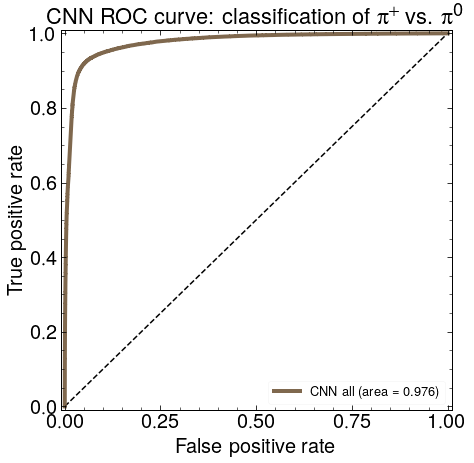

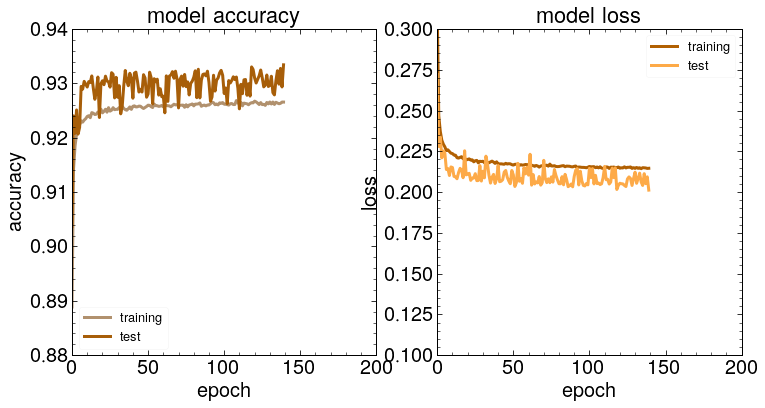

In [16]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=140, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,200)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,200)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #okay so this is starting to do better, lets try a different combo
plt.legend()

In [17]:
#TRY: smaller l2 and dropout values -> pretty much same as above but with one less dropout each

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.1)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu')(x)
    x = Dense(50, activation='relu')(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/50
1633/1633 [==============================] - 22s 12ms/step - loss: 0.3985 - accuracy: 0.8553 - val_loss: 0.2580 - val_accuracy: 0.9075
Epoch 2/50
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2506 - accuracy: 0.9127 - val_loss: 0.2351 - val_accuracy: 0.9181
Epoch 3/50
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2349 - accuracy: 0.9185 - val_loss: 0.2293 - val_accuracy: 0.9212
Epoch 4/50
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2307 - accuracy: 0.9201 - val_loss: 0.2303 - val_accuracy: 0.9220
Epoch 5/50
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2262 - accuracy: 0.9212 - val_loss: 0.2223 - val_accuracy: 0.9236
Epoch 6/50
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2234 - accuracy: 0.9225 - val_loss: 0.2147 - val_accuracy: 0.9277
Epoch 7/50
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2205 - accuracy: 0.9245 - val_loss: 0.2143 -

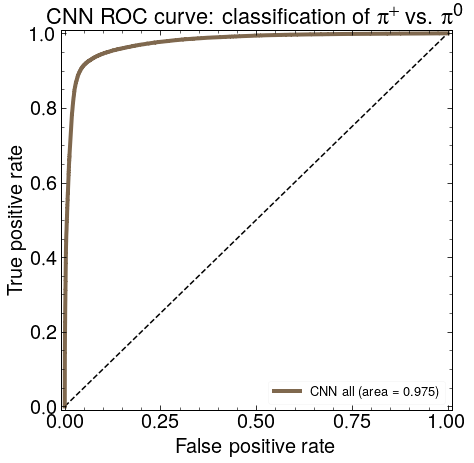

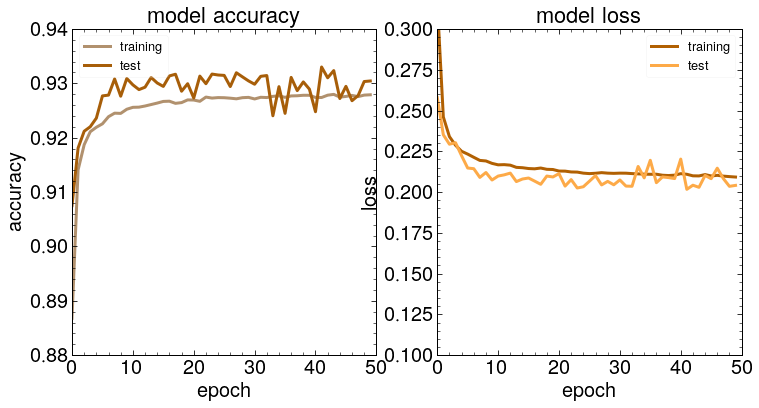

In [18]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=50, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,50)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,50)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #one less dropout each, same smaller dropout/reg... pretty much same?
plt.legend()

In [19]:
#try something else - dropout/reg at the end instead of in here??!!

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu',data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu',data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu',  data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.2)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 19s 10ms/step - loss: 0.3702 - accuracy: 0.8519 - val_loss: 0.2332 - val_accuracy: 0.9147
Epoch 2/200
1633/1633 [==============================] - 16s 10ms/step - loss: 0.2291 - accuracy: 0.9160 - val_loss: 0.2090 - val_accuracy: 0.9241
Epoch 3/200
1633/1633 [==============================] - 16s 10ms/step - loss: 0.2150 - accuracy: 0.9213 - val_loss: 0.2009 - val_accuracy: 0.9286
Epoch 4/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2094 - accuracy: 0.9238 - val_loss: 0.1966 - val_accuracy: 0.9292
Epoch 5/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2063 - accuracy: 0.9252 - val_loss: 0.1949 - val_accuracy: 0.9301
Epoch 6/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2024 - accuracy: 0.9259 - val_loss: 0.1964 - val_accuracy: 0.9301
Epoch 7/200
1633/1633 [==============================] - 16s 10ms/step - loss: 0.1996 - accuracy: 0.9276 - val_loss: 0

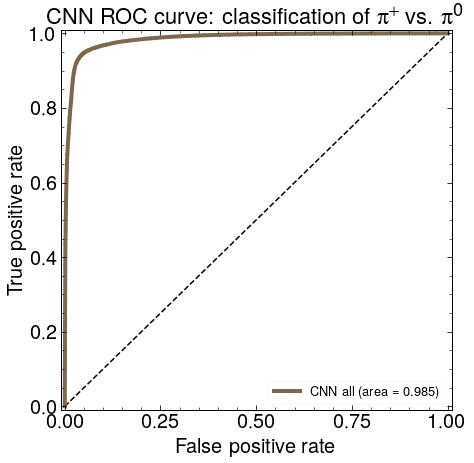

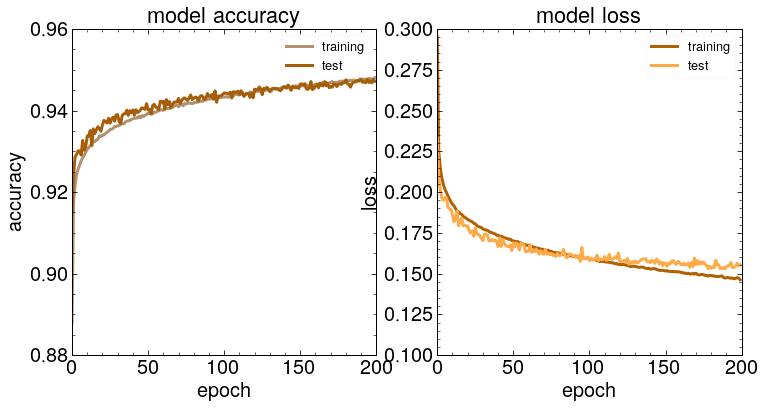

In [20]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,200)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,200)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #I don't think this is enough but maybe a combo like this? this is better but still does start to overfit!!
plt.legend()

In [12]:
#try something else - dropout/reg at the end instead, plus a couple reg up here

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.2)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 19s 11ms/step - loss: 0.4026 - accuracy: 0.8433 - val_loss: 0.2398 - val_accuracy: 0.9157
Epoch 2/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2451 - accuracy: 0.9128 - val_loss: 0.2252 - val_accuracy: 0.9215
Epoch 3/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2314 - accuracy: 0.9177 - val_loss: 0.2160 - val_accuracy: 0.9235
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2277 - accuracy: 0.9193 - val_loss: 0.2159 - val_accuracy: 0.9239
Epoch 5/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2224 - accuracy: 0.9218 - val_loss: 0.2145 - val_accuracy: 0.9252
Epoch 6/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2211 - accuracy: 0.9226 - val_loss: 0.2129 - val_accuracy: 0.9287
Epoch 7/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2190 - accuracy: 0.9232 - val_loss: 0

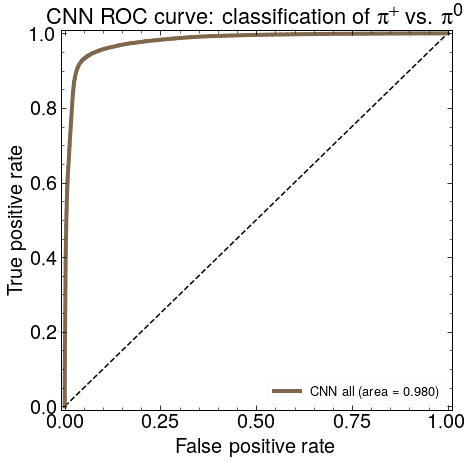

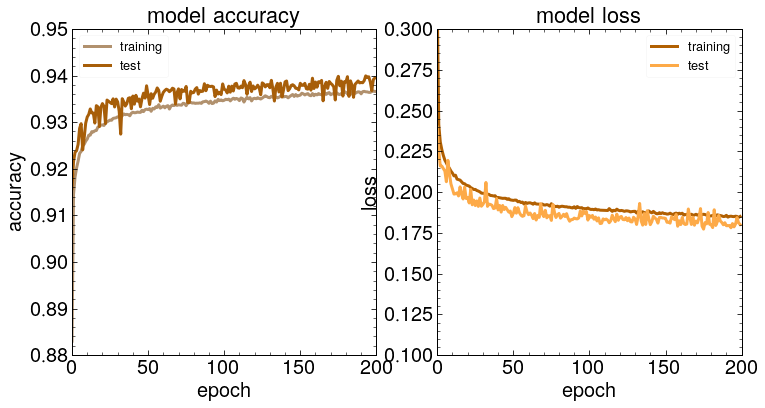

In [22]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,200)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,200)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #This seems to do pretty well atually!!!1
plt.legend()

Epoch 1/400
1633/1633 [==============================] - 27s 13ms/step - loss: 0.3991 - accuracy: 0.8494 - val_loss: 0.2455 - val_accuracy: 0.9122
Epoch 2/400
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2475 - accuracy: 0.9129 - val_loss: 0.2243 - val_accuracy: 0.9221
Epoch 3/400
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2334 - accuracy: 0.9186 - val_loss: 0.2163 - val_accuracy: 0.9258
Epoch 4/400
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2255 - accuracy: 0.9210 - val_loss: 0.2172 - val_accuracy: 0.9235
Epoch 5/400
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2237 - accuracy: 0.9221 - val_loss: 0.2098 - val_accuracy: 0.9276
Epoch 6/400
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2191 - accuracy: 0.9238 - val_loss: 0.2107 - val_accuracy: 0.9289
Epoch 7/400
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2164 - accuracy: 0.9252 - val_loss: 0

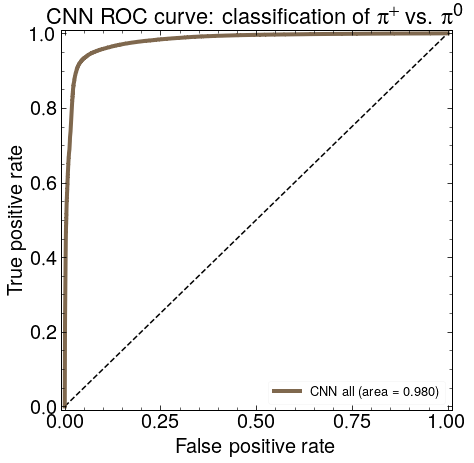

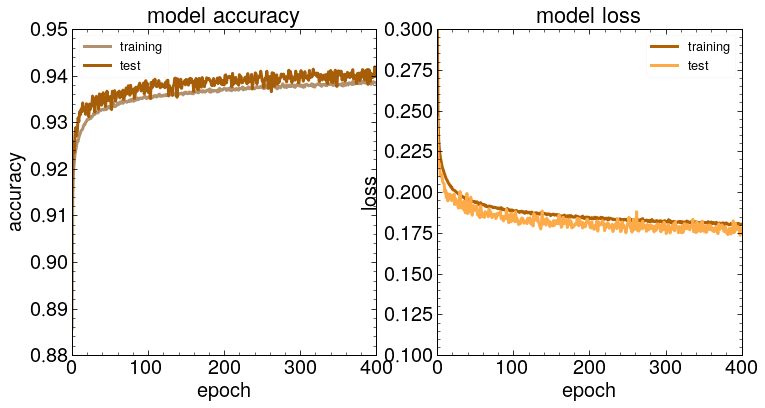

In [13]:
#same model as above but for longer as it still seems to be improving!
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=400, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,400)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,400)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') 
plt.legend()

Okay so this is pretty good!! doesn't appear to be overfitting, continues to improve slowly, nice. Move now to week4_moremerged for more merged models, making small changes to the reg and dropout values to see if I can get it any better. But I think this is good! NOTE - made a better one in week4! 

In [14]:
#okay fine one more: if I make the last regualrizers to .0001 instead of .001 can I get a better accuracy...?

def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001),data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)
    x = Dropout(.2)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/400
1633/1633 [==============================] - 22s 12ms/step - loss: 0.3744 - accuracy: 0.8461 - val_loss: 0.2322 - val_accuracy: 0.9169
Epoch 2/400
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2373 - accuracy: 0.9146 - val_loss: 0.2212 - val_accuracy: 0.9228
Epoch 3/400
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2253 - accuracy: 0.9201 - val_loss: 0.2111 - val_accuracy: 0.9270
Epoch 4/400
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2193 - accuracy: 0.9223 - val_loss: 0.2069 - val_accuracy: 0.9283
Epoch 5/400
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2154 - accuracy: 0.9240 - val_loss: 0.2018 - val_accuracy: 0.9305
Epoch 6/400
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2131 - accuracy: 0.9248 - val_loss: 0.2052 - val_accuracy: 0.9296
Epoch 7/400
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2124 - accuracy: 0.9248 - val_loss: 0

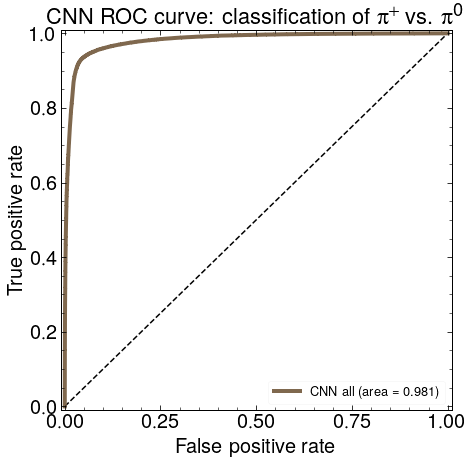

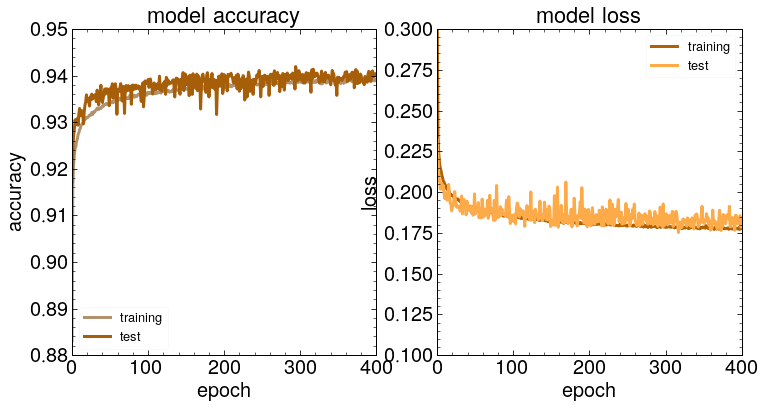

In [15]:
mergedmrd = merged_model_regd()
#same number of increased dense layers, a bit less regularization and dropout
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=400, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:dark taupe', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,400)
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:pale brown', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:raw umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,400)
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:orangey brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:light orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') 
plt.legend()

In [ ]:
#so this one does start to overfit too... so last one was the best!!